# Data Challenge for _Some Company_
### Rosamaria Carraro
This is "data challenge" I performed for a technical interview for a Data Scientist position, in order to show my mastery in a dataset exploration and in the training of an ML model.

I was going to be evaluated based on the work method, the important steps in the 4 work phases (EDA, Feature engineering, model training, performance evaluation), the markdown comments, the overall clearness of the analysis and the reasoning behind the choices made.

I was _not_ going to be evaluated based on the length of the notebook, the performance of the model and the choice of libraries.

The aim of the [Kaggle competition](https://www.kaggle.com/c/tabular-playground-series-sep-2021/data) this data challenge was extracted from, is to predict whether a customer made a claim upon an insurance policy. 
The features in the dataset have been anonymized and may contain missing values.

This is a classification problem, so I am going to consider some of the most common classifiers, choose one, and face the challenge following the guidelines contained in the email.

## Possible considered classifiers
### K-Nearest Neighbors (KNN) Classifier
The number of neighbors is the core deciding factor. Vote for labels

It's lazy. Lazy algorithm means it does not need any training data points for model generation. All training data used in the testing phase. This makes training faster and testing phase slower and costlier.

It suffers from the Curse of Dimensionality, so it performs better with a lower number of features. A valid approach is therefore to perform principal component analysis (PCA) before applying any machine learning algorithm.

This seems like a good option since we are not looking for the best model performance in this exercise, and by reducing the number of features we can get a relatively fast model that we can tune and then study its results. Furthermore, this gives us the chance to use also an unsupervised model, the PCA.

### SVM
The objective of Support Vector Machines is to select a hyperplane with the maximum possible margin between support vectors in the given dataset. This makes it not suitable for large datasets because of its high training time.
It also needs a clear margin of separation and with high dimensional space in order to work well, and it performs poorly with overlapping classes. 

This kind of classifier seems less like a good option in this case as it is very time demanding. Furthermore it is sensitive to the kernel choice, so tuning it would take even longer. Finally, we don't know if our classes are overlapping, but again, we are not that interested in the performance so this is a minor issue.

### Naive Bayes classifier
Naive Bayes is a statistical classification technique based on Bayes Theorem. Naive Bayes classifier assumes that the effect of a particular feature in a class is independent of other features.

It may be worth considering as it is a simple approach and also a fast and accurate method for prediction with very low computation cost.
It can efficiently work on a large dataset and it performs well in case of discrete response variable. When the assumption of independence holds it works very well but since our features have been anonymized, there is no way for us to know whether this is the case.

### Logistic Regression
Logistic Regression is one of the most simple and commonly used Machine Learning algorithms for binary classification problems, which is the kind of problem we are dealing with. It is efficient and straightforward, it doesn't require high computation power, it's easy to implement, and easily interpretable. It doesn't even require scaling of features. This seems like the obvious choice but it is not able to handle a large number of categorical features, so we would still need to apply PCA and it is not possible to solve the non-linear problem with the logistic regression that is why it requires a transformation of non-linear features.

### My choice: PCA + KNN
Even though there are other choices worth considering, I choose to use a KNN classifier because it gives me the opportunity to use a light dataset, to perform variable rescaling and hyper-parameter tuning, and to use PCA as well. Furthermore, I can perform some additional data exploration with the help of PCA.



In order to apply the KNN classifier, I need to reduce the dimensionality of the dataset. To this aim I am going to apply Principal Component Analysis (PCA). PCA is an unsupervised machine learning algorithm who realigns our dataset to a different frame of reference in which the variances along its axis (the components) are maximized. The components are sorted from greater to smaller variance. This allows us to approximate the dataset by using only the components which contain most of the information.

First of all, let us import the packages we need:

In [1]:
# basic imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
from matplotlib.ticker import MultipleLocator
import seaborn as sns # nicer plots

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# plotting default settings for better images
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams['figure.dpi']= 300

# 1 Exploratory Data Analysis

Let us start by reading our datasets and checking their column names:

In [2]:
# data read
df = pd.read_csv('./tabular-playground-series-sep-2021/train.csv',index_col='id')
df.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       ...
       'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118',
       'claim'],
      dtype='object', length=119)

In [3]:
df_test=pd.read_csv('./tabular-playground-series-sep-2021/test.csv',index_col='id')
df_test.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       ...
       'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117',
       'f118'],
      dtype='object', length=118)

We can see that all the features were in fact anonymized and their names are basically a numerical sequence, ranging from 1 to 118, which is quite a large amount of features.

We notice that the `test.csv` dataset does not include our target variable, `'claim'`. In order to be able to present how the model performed, I'm going to use only the `train.csv` dataset, for both training and testing. Using less data for training will probably worsen the model's performance, but for this exercise we are not too interested in getting the best accuracy.

Let us continue checking the data with a few summaries:

In [4]:
df.shape

(957919, 119)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957919 entries, 0 to 957918
Columns: 119 entries, f1 to claim
dtypes: float64(118), int64(1)
memory usage: 877.0 MB


In [6]:
df.head()

f1        f2         f3        f4       f5        f6       f7  \
id                                                                       
0   0.10859  0.004314    -37.566  0.017364  0.28915 -10.25100   135.12   
1   0.10090  0.299610  11822.000  0.276500  0.45970  -0.83733  1721.90   
2   0.17803 -0.006980    907.270  0.272140  0.45948   0.17327  2298.00   
3   0.15236  0.007259    780.100  0.025179  0.51947   7.49140   112.51   
4   0.11623  0.502900   -109.150  0.297910  0.34490  -0.40932  2538.90   

          f8            f9        f10  ...     f110    f111     f112  \
id                                     ...                             
0   168900.0  3.992400e+14     86.489  ... -12.2280  1.7482  1.90960   
1   119810.0  3.874100e+15   9953.600  ... -56.7580  4.1684  0.34808   
2   360650.0  1.224500e+13  15827.000  ...  -5.7688  1.2042  0.26290   
3   259490.0  7.781400e+13    -36.837  ... -34.8580  2.0694  0.79631   
4    65332.0  1.907200e+15    144.120  ... -13.6410  1.5298  1.14640   

        f113      f114    f115          f116    f117     f118  claim  
id                                                                    
0   -7.11570   4378.80  1.2096  8.613400e+14   140.1  1.01770      1  
1    4.14200    913.23  1.2464  7.575100e+15  1861.0  0.28359      0  
2    8.13120  45119.00  1.1764  3.218100e+14  3838.2  0.40690      1  
3  -16.33600   4952.40  1.1784  4.533000e+12  4889.1  0.51486      1  
4   -0.43124   3856.50  1.4830 -8.991300e+12     NaN  0.23049      1  

[5 rows x 119 columns]

- We have 957919 rows, which are observations of customers who either made a claim or not, to their insurance.
- The possible claim is to be predicted by 118 features. These features are all in float form, so we don't have to deal with string type of data.
- Our target variable, `claim`, is presented in integer form and has only 0 and 1 values, with 0 meaning no claim, and 1 meaning claim.

In [7]:
df.describe()

f1             f2             f3             f4  \
count  942672.000000  942729.000000  942428.000000  942359.000000   
mean        0.090201       0.345964    4068.744207       0.201214   
std         0.043564       0.146251    6415.829440       0.212510   
min        -0.149910      -0.019044   -9421.700000      -0.082122   
25%         0.070227       0.283050     418.430000       0.035086   
50%         0.090135       0.389100    1279.500000       0.137000   
75%         0.116500       0.458450    4444.400000       0.297100   
max         0.415170       0.518990   39544.000000       1.319900   

                  f5             f6             f7            f8  \
count  942514.000000  942398.000000  942415.000000  9.425460e+05   
mean        0.304869      -0.071458    1620.843815  3.771642e+05   
std         0.145343       2.123777    1276.281403  3.454325e+05   
min        -0.006990     -12.791000    -224.800000 -2.984300e+04   
25%         0.240520      -1.120700     481.545000  9.120900e+04   
50%         0.327790      -0.380110    1446.100000  2.896700e+05   
75%         0.412830       0.921940    2495.900000  5.605600e+05   
max         0.554750      11.202000    5426.600000  1.913700e+06   

                 f9            f10  ...           f110           f111  \
count  9.426700e+05  942696.000000  ...  942554.000000  942420.000000   
mean   1.806054e+15    5323.442367  ...     -19.926398       2.074530   
std    2.335204e+15   10068.380032  ...      18.578439       0.895793   
min   -1.153300e+15  -26404.000000  ...    -105.860000       0.277040   
25%    1.153100e+13      75.876750  ...     -28.812000       1.487700   
50%    5.043050e+14    1073.200000  ...     -14.636000       1.662100   
75%    3.103100e+15    5693.200000  ...      -5.325300       2.522325   
max    1.042400e+16   85622.000000  ...       1.613400       4.565900   

                f112           f113           f114           f115  \
count  942509.000000  942686.000000  942481.000000  942360.000000   
mean       23.885245       1.748777   63152.973540       1.208876   
std        45.581360      10.088848   92435.016241       0.114959   
min       -27.691000     -26.589000  -81977.000000       0.905270   
25%        -0.628880      -4.473975    2443.200000       1.146800   
50%         1.727700       0.885710   19479.000000       1.177200   
75%        18.991000       6.840775   88488.000000       1.242000   
max       217.840000      47.757000  526050.000000       1.886700   

               f116           f117           f118          claim  
count  9.423300e+05  942512.000000  942707.000000  957919.000000  
mean   4.276905e+16    3959.204669       0.559267       0.498492  
std    6.732441e+16    3155.991777       0.408426       0.499998  
min   -8.944400e+15    -415.240000      -0.151240       0.000000  
25%    2.321100e+14    1306.200000       0.276560       0.000000  
50%    1.327500e+16    3228.000000       0.473440       0.000000  
75%    5.278700e+16    6137.900000       0.746210       1.000000  
max    3.249900e+17   13151.000000       2.743600       1.000000  

[8 rows x 119 columns]

- The other summaries of the dataframe are not complete as there are too many features to visualize and, were we able to see them all, it would be too much information to handle at a glance. The summary statistics provided by the `.describe()` method of the dataframe, still shows that the features cover various orders of magnitude.

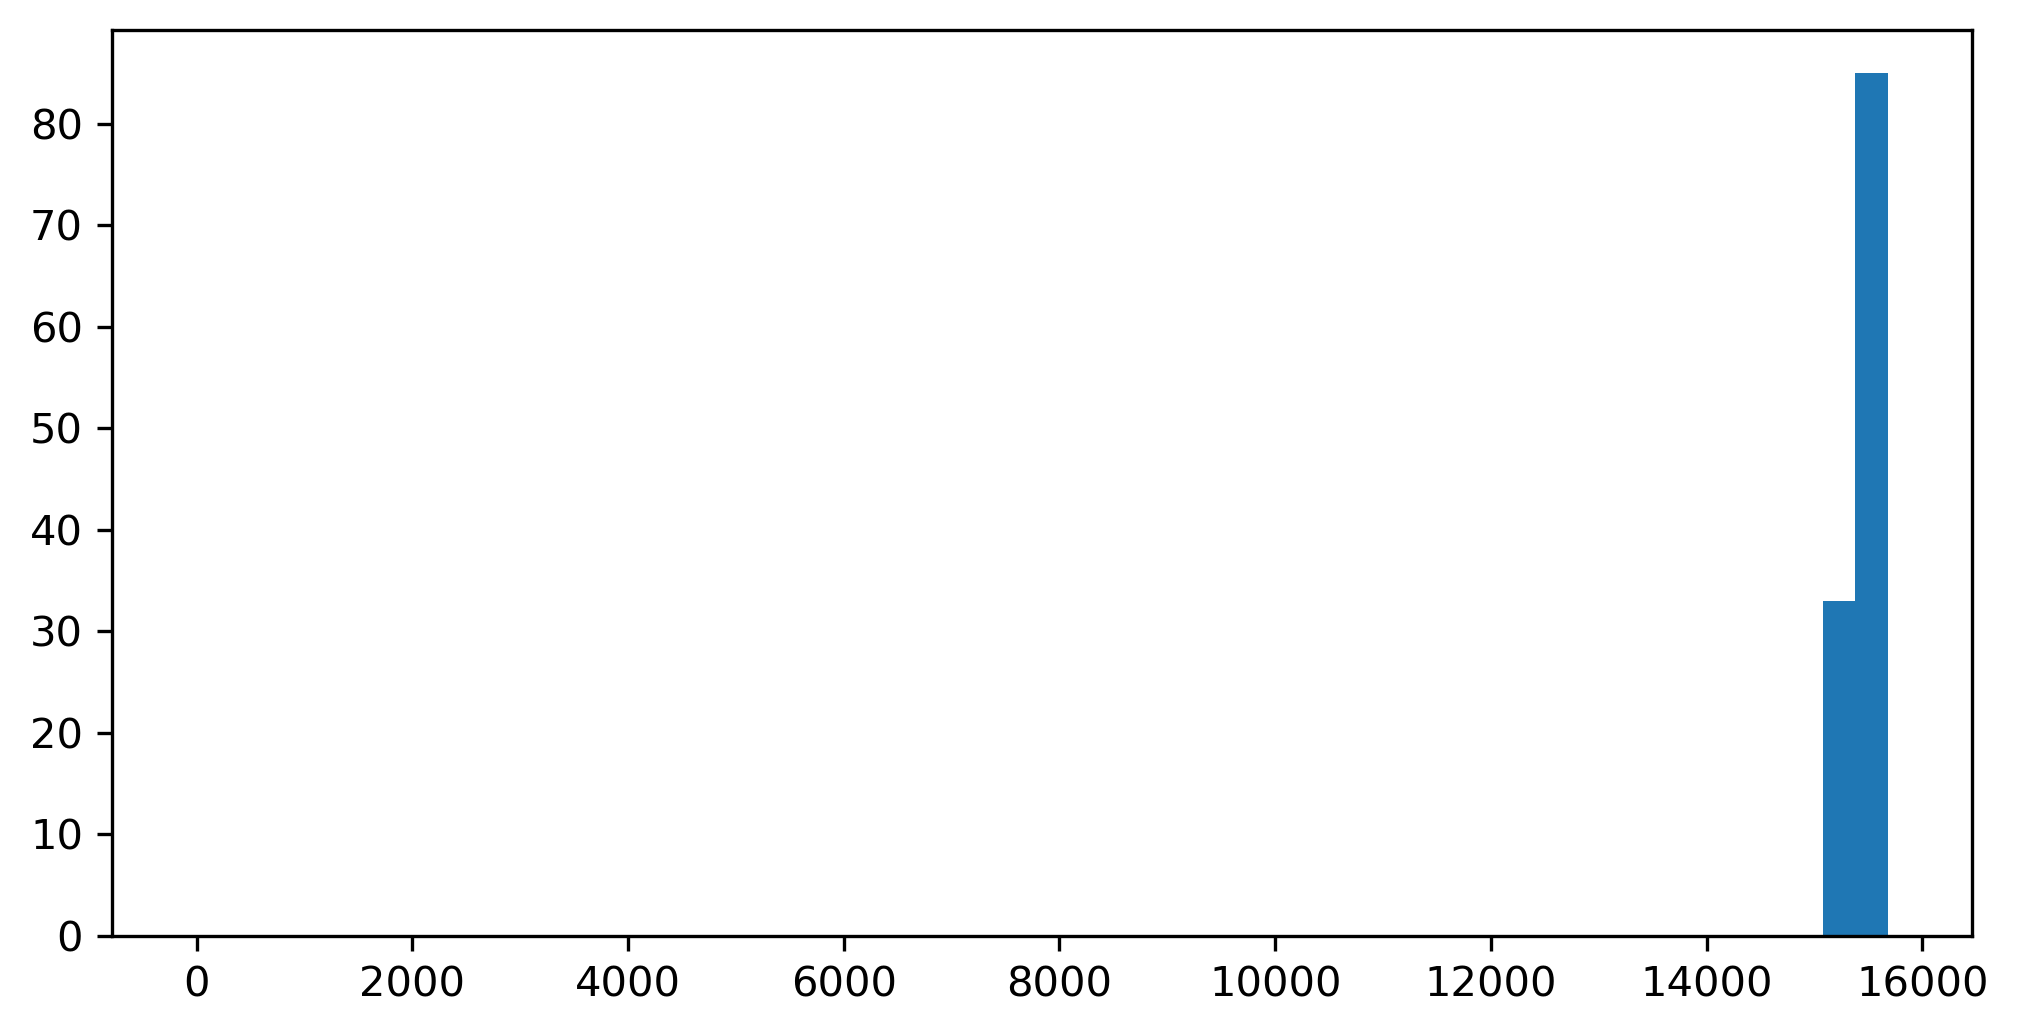

Number of rows with at least 1 missing value: 598455


In [8]:
nan_df=df.isnull().sum()
nan_df.hist(bins=np.logspace(start=np.log10(1), stop=np.log10(nan_df.max()), num=500),grid=False)
plt.show()
print(f'Number of rows with at least 1 missing value: {len(df) - len(df.dropna())}')

- Most features have an amount of missing data of ~15.000 entries. These are not so many, but the total number of rows that have at least 1 missing values is about half the size of the dataframe, so we need to deal with these missing values, or else we would end up dropping too many entries.

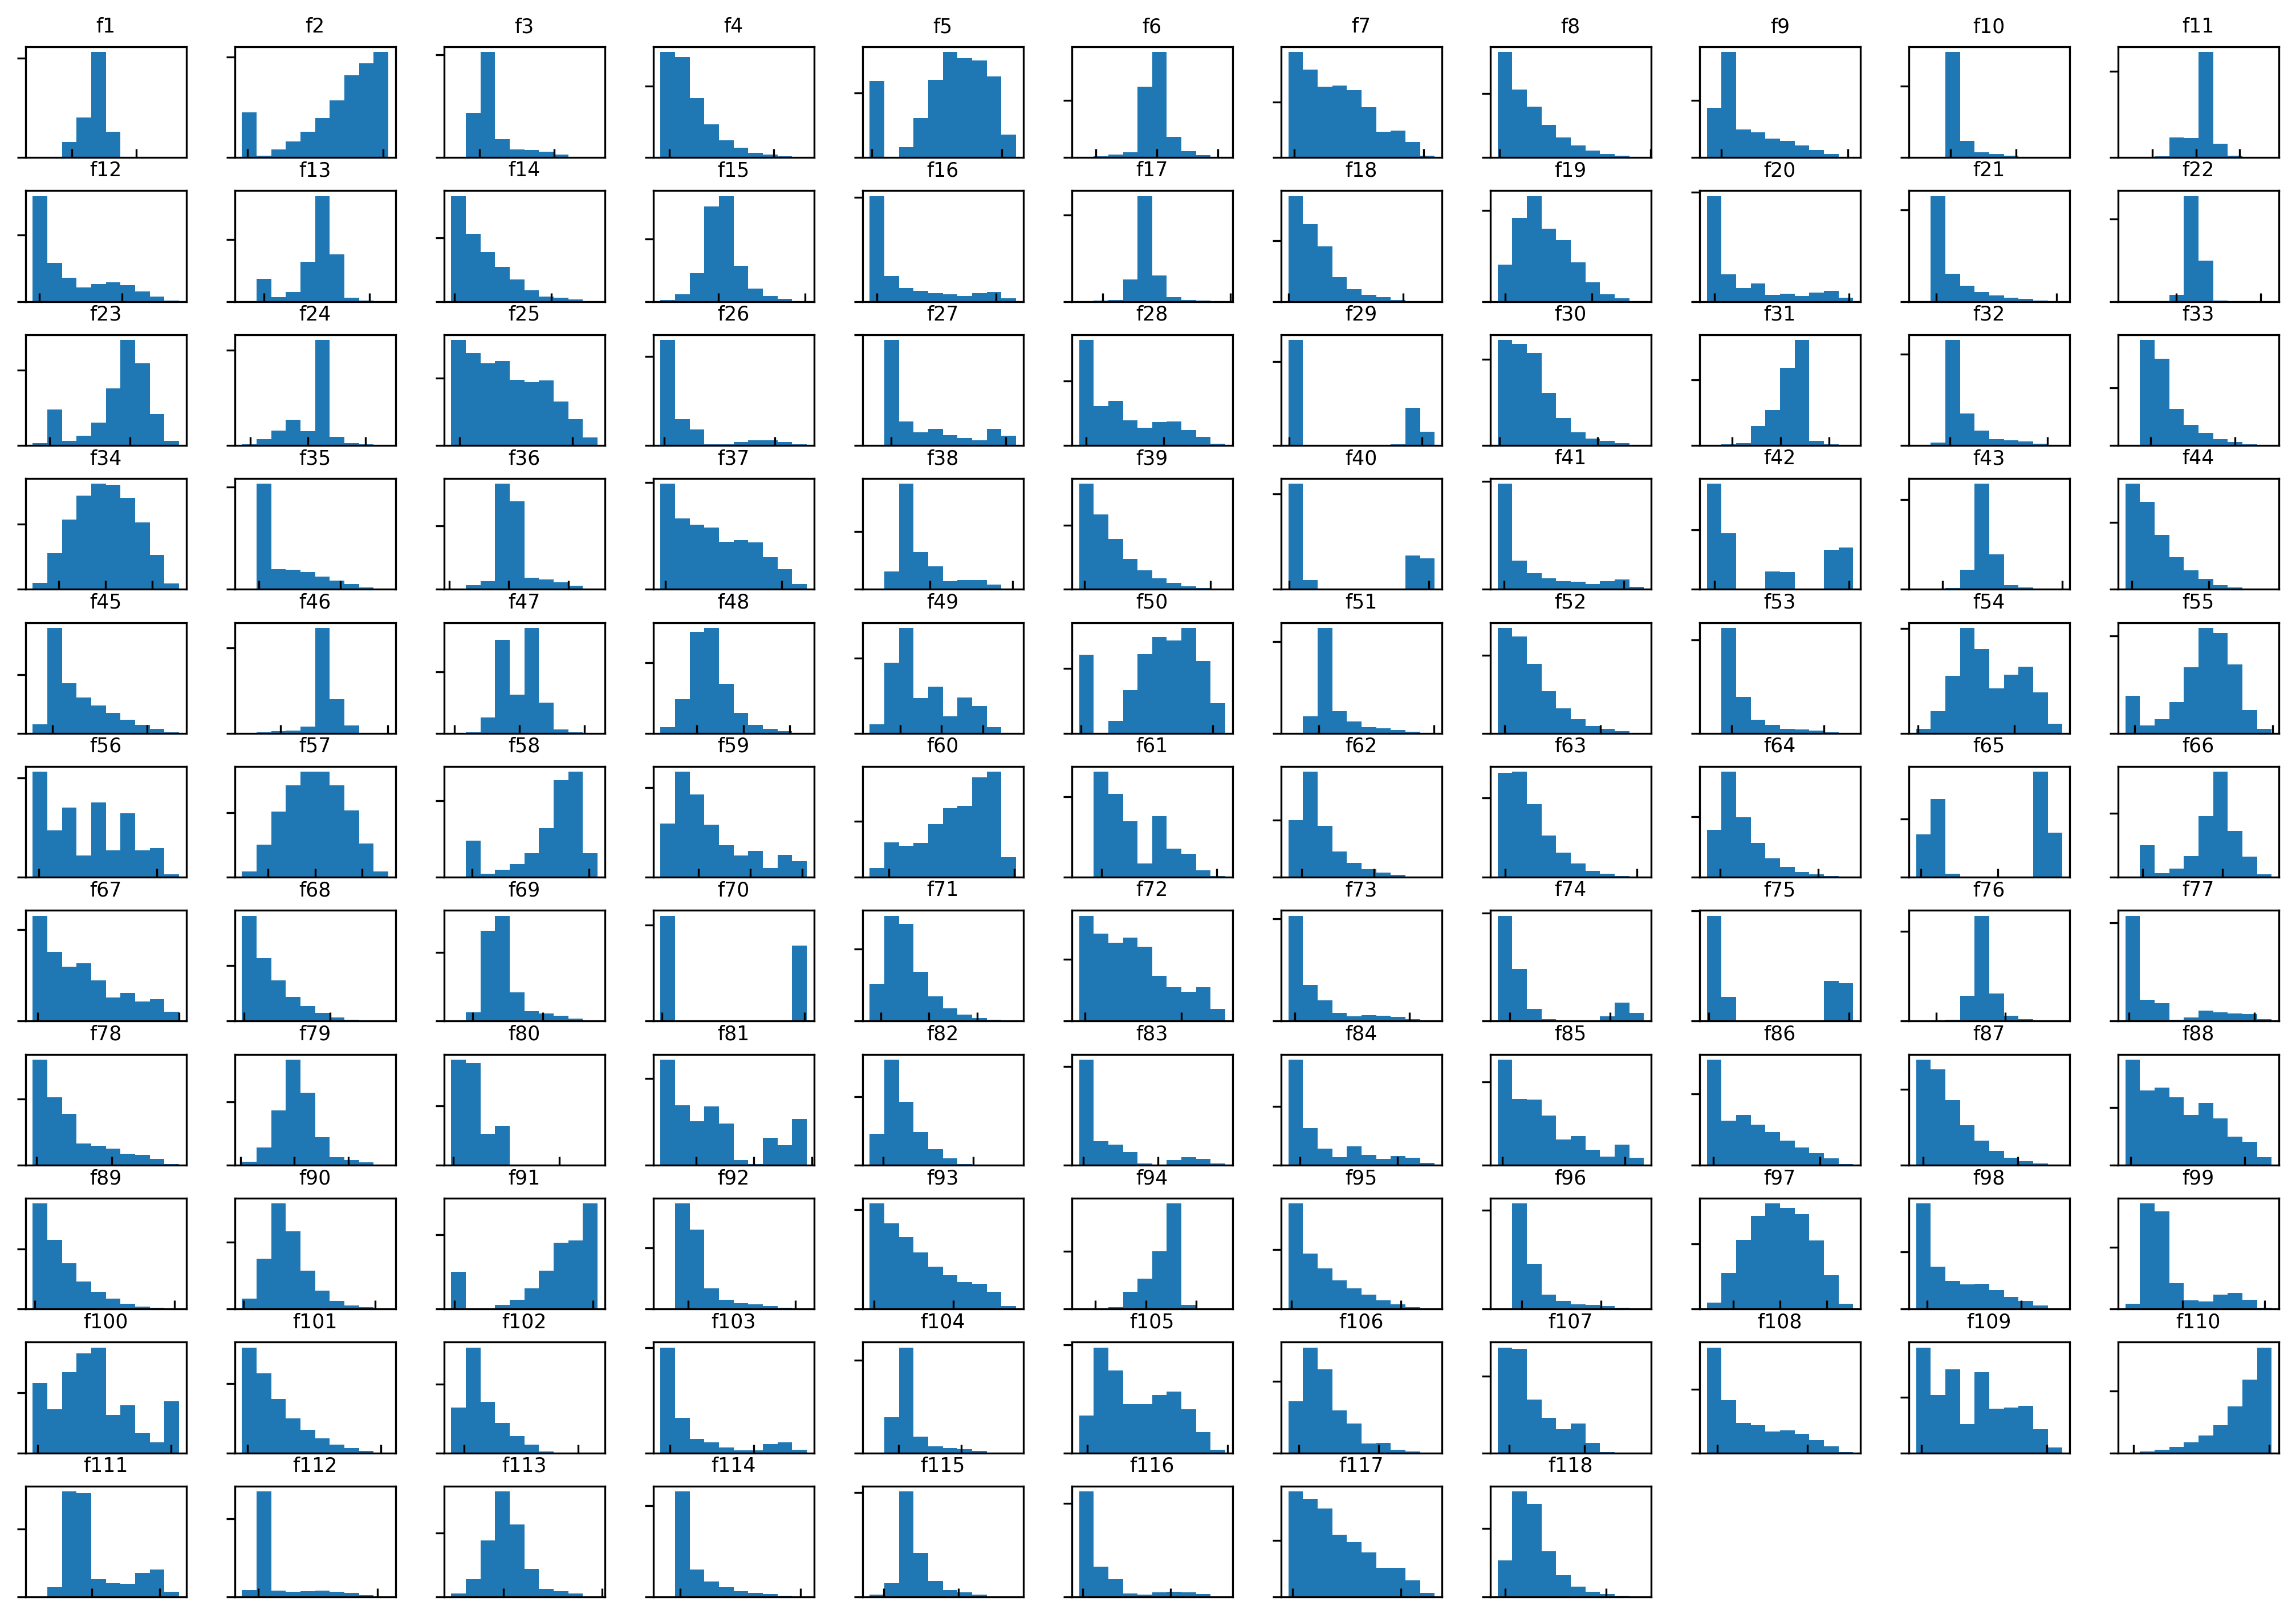

In [9]:
plt.rcParams["axes.titlesize"] = 'small'
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.labelbottom']= False
plt.rcParams['ytick.labelleft']= False
plt.rcParams['ytick.labelsize']= 'small'

axs = df.drop('claim', axis=1).hist(figsize=(17, 12),grid=False)
plt.axis('off')
plt.show();
plt.rcParams["axes.titlesize"] = 'large'
plt.rcParams['xtick.direction']= 'out'
plt.rcParams['xtick.labelbottom']= True
plt.rcParams['ytick.labelleft']= True
plt.rcParams['ytick.labelsize']= 'medium'

In [10]:
# f70 seems categorical (binary), but it is not
df['f70'].value_counts

<bound method IndexOpsMixin.value_counts of id
0         0.995190
1         1.005100
2         0.992780
3         1.007000
4         0.989850
            ...   
957914    0.991180
957915   -0.005993
957916    0.005923
957917   -0.003622
957918   -0.004873
Name: f70, Length: 957919, dtype: float64>

- From a visual inspection of the distribution of the variables we notice some gaussian-like distributions, some skewed distributions and some who are closer to a binary tipe of variable, which may be a categorical variable. By inspecting f70 in particular, we can see that it is not.


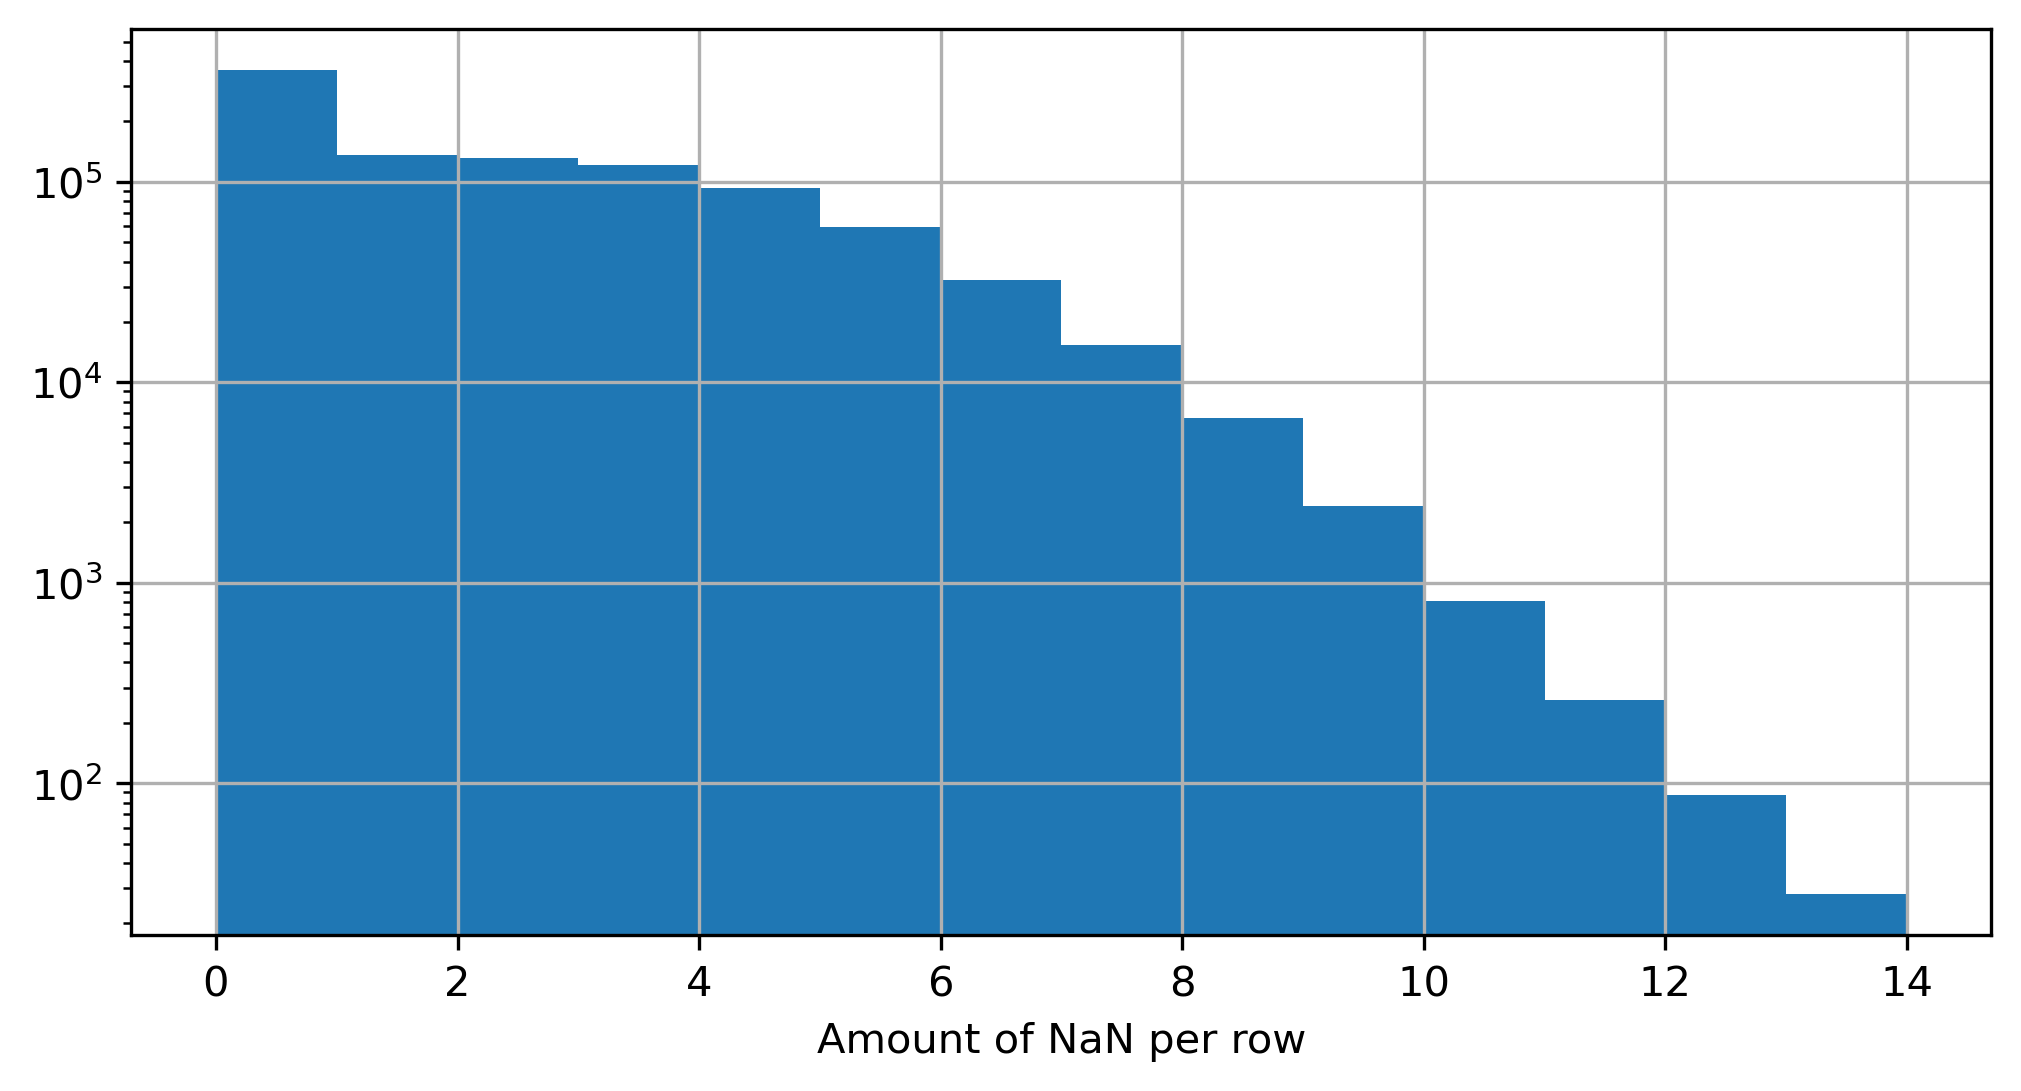

In [11]:
# count nan in rows
df.isnull().sum(axis=1).hist(bins=14)
plt.xlabel('Amount of NaN per row')
plt.yscale('log')
plt.show()

- The number of missing values per row is generally quite small compared to the total number of features, so we can keep all of our rows.

Finally we want to check for class imbalance, i.e. if the labels of our target variable are well distributed or some label is particularly rare. In our case we have a binary classification problem, so it is particularly easy to check:

In [12]:
claim_distrib=df["claim"].astype("bool").describe()
print(f'The most frequent claim label is {claim_distrib.top} and its frequency is {claim_distrib.freq/df.shape[0]*100:.1f}%.')

The most frequent claim label is False and its frequency is 50.2%.


- The target variable is quite well balanced, as either value is present in about 50% of the cases.

Some additional data exploration, like feature correlation, is performed in the following section. This is because the dataset is too large to visualize effectively, and it is easier to visualize our data after the PCA.

# 2 Feature engineering
Since we are dealing with numeric (float) features only, there are two main steps we need to perform before we can use it with our KNN model:

- Deal with missing entries
- Rescale the features. This is necessary as KNN relies on the distance between data-points.

Luckily we don't have to deal with categorical, or text features, which would require a different treatment, like dummy variables and One Hot encoding, since our model can only accept numerical features.

Additionally, we are going to apply PCA to reduce the dimensionality of our dataset before we can train the KNN model.

Let us start by separating our features (`X`) from our target variable (`y`), these will need to be numpy arrays as the models cannot handle dataframes:

In [13]:
X = df.drop('claim', axis=1).values
y = df['claim'].values

Then, we want to split the data into training and test samples. 

The default `test_size=0.25` (25% of the labeled data) is a good rule of thumb so we are not changing it.

We also set `stratify=y` in order for the labels (0-1) to be equally distributed among test and training set.

Finally, we set the random seed value for reproducibility reasons, so that running the line again will result in the same splitting of the data.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, stratify=y)

In order to fill missing entries we use the `SimpleImputer`, which will substitute these entries (`NaN`) with the median value of that feature. This is an easy and fast approach that allows us not to lose many rows of data, even though it is not so accurate, and does not keep into account possible correlations between features. We choose to use the median instead of the mean as it is less sensitive to outliers.
There are more robust approaches, such as the KNN imputer, but we choose not to use it as it is quite computationally expensive.

In [15]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(X_train)
X_train = imp.transform(X_train)
np.isnan(X_train).any() # check that no NaN values are left

False

Now we are finally ready to apply PCA to our dataset. First we explore the variance of the components in order to choose how many to use:

In [16]:
model = PCA()
model.fit(X_train)
transformed = model.transform(X_train)

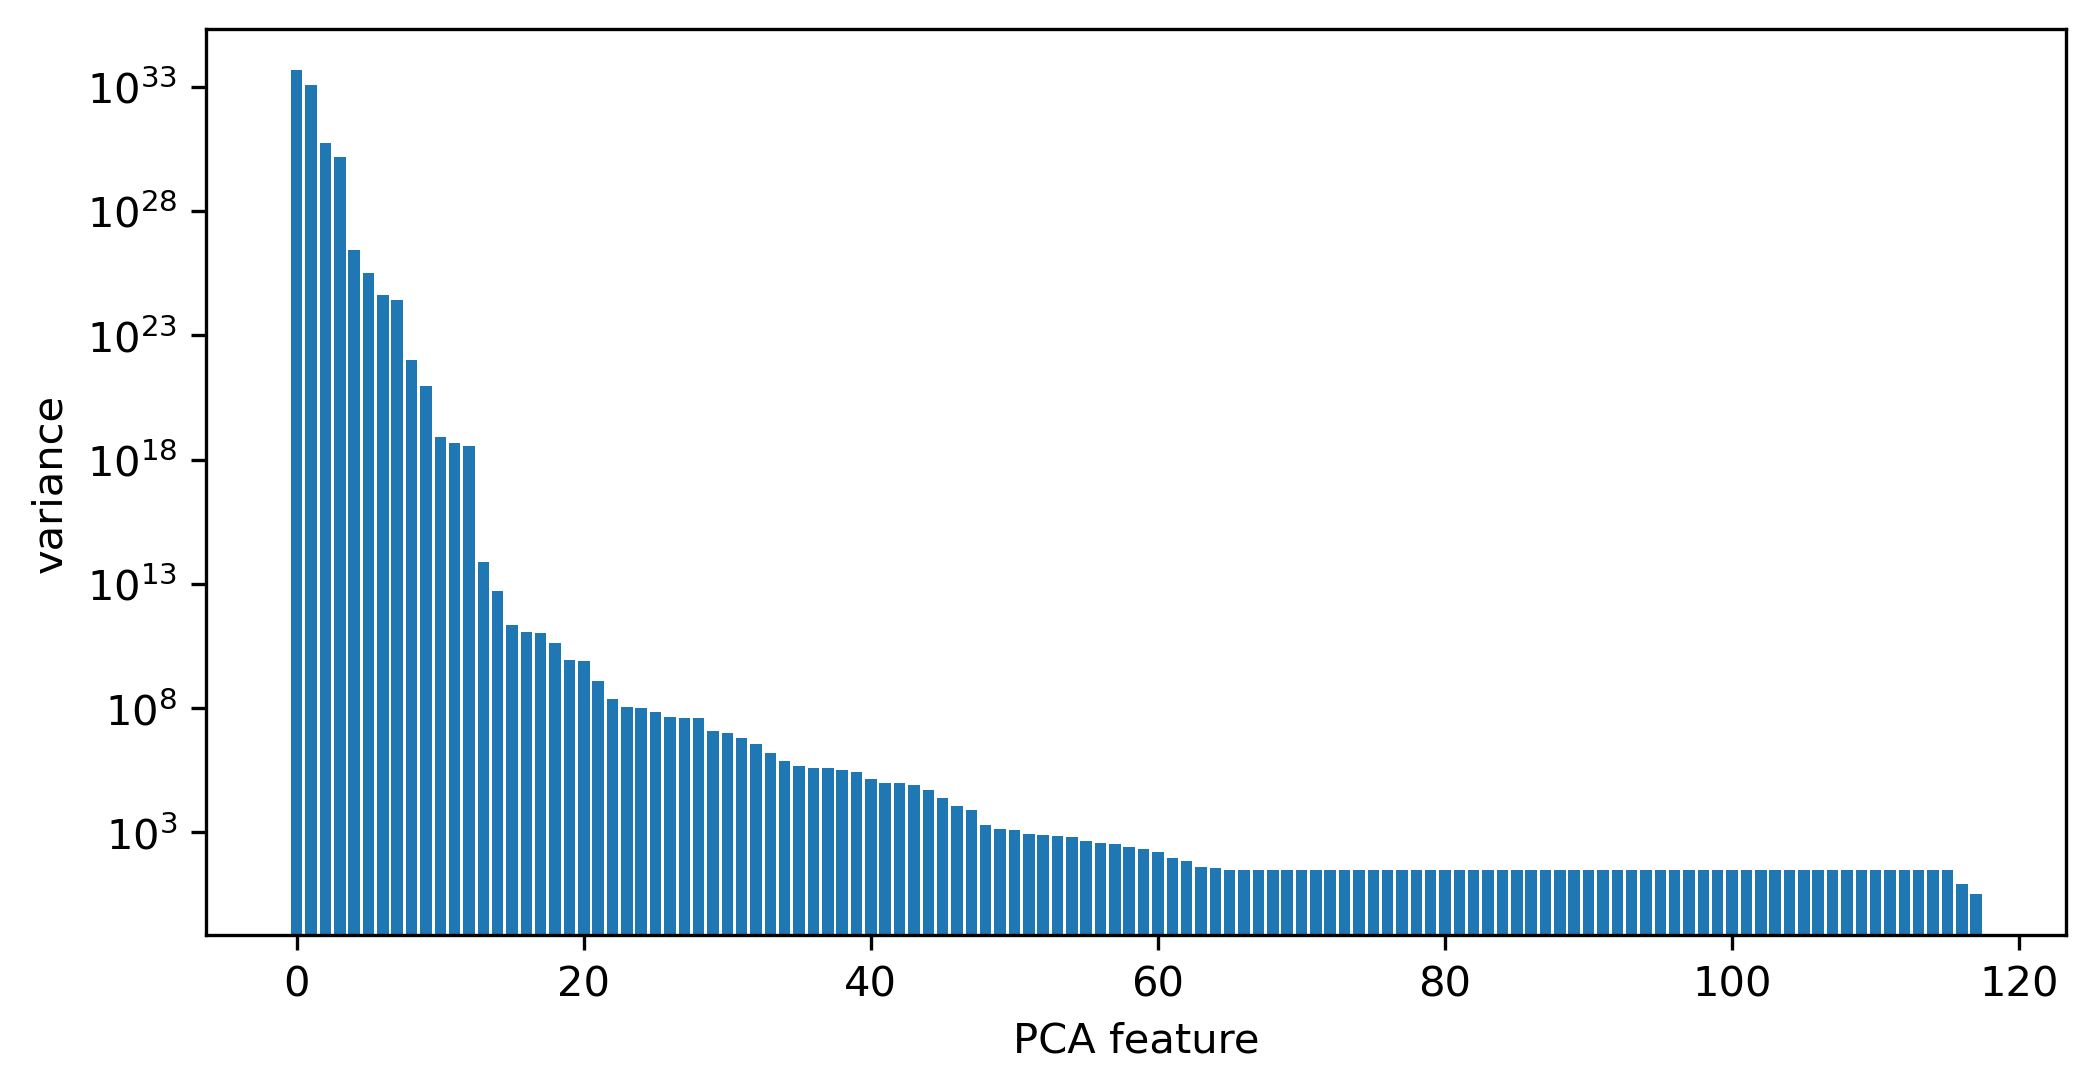

In [7]:
features = range(model.n_components_)

plt.bar(features, model.explained_variance_)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.yscale('log')
plt.show()

In [28]:
print('Number of PCA features with variance greater than threshold:')
print(f'n = {(model.explained_variance_>1e28).sum()} , above 1e28')
print(f'n = {(model.explained_variance_>1e23).sum()} , above 1e23')
print(f'n = {(model.explained_variance_>1e13).sum()}, above 1e13')

Number of PCA features with variance greater than threshold:
n = 4 , above 1e28
n = 8 , above 1e23
n = 14, above 1e13


We want to keep the number of features below ~10 for KNN to work best. We can see from the above plot that the first 4 PCA features have a greater variance by a few orders of magnitude than the following ones. It could be reasonable to include a few more PCA features, up to 8 for example, where we see another steep(ish) decrease in the variance, but we are going to limit ourselves to just 4 PCA features in order to keep it light for my laptop and be able to fine tune our `k` hyper-parameter of the model.

We also notice that the next steep decrease in variance is at $\sigma^2 \approx 10^{13}$, but 14 features are already too many for a KNN classifier because of the curse of dimensionality.

Now we fit and transform our dataset in order for it to be composed only by the first 4 PCA features:

In [9]:
pca = PCA(n_components=4)
pca.fit(X_train) 

transformed = pca.transform(X_train)
print(transformed.shape) 
df_pca = pd.DataFrame(transformed,columns=['pca_f'+str(n) for n in np.arange(4)])

(718439, 4)


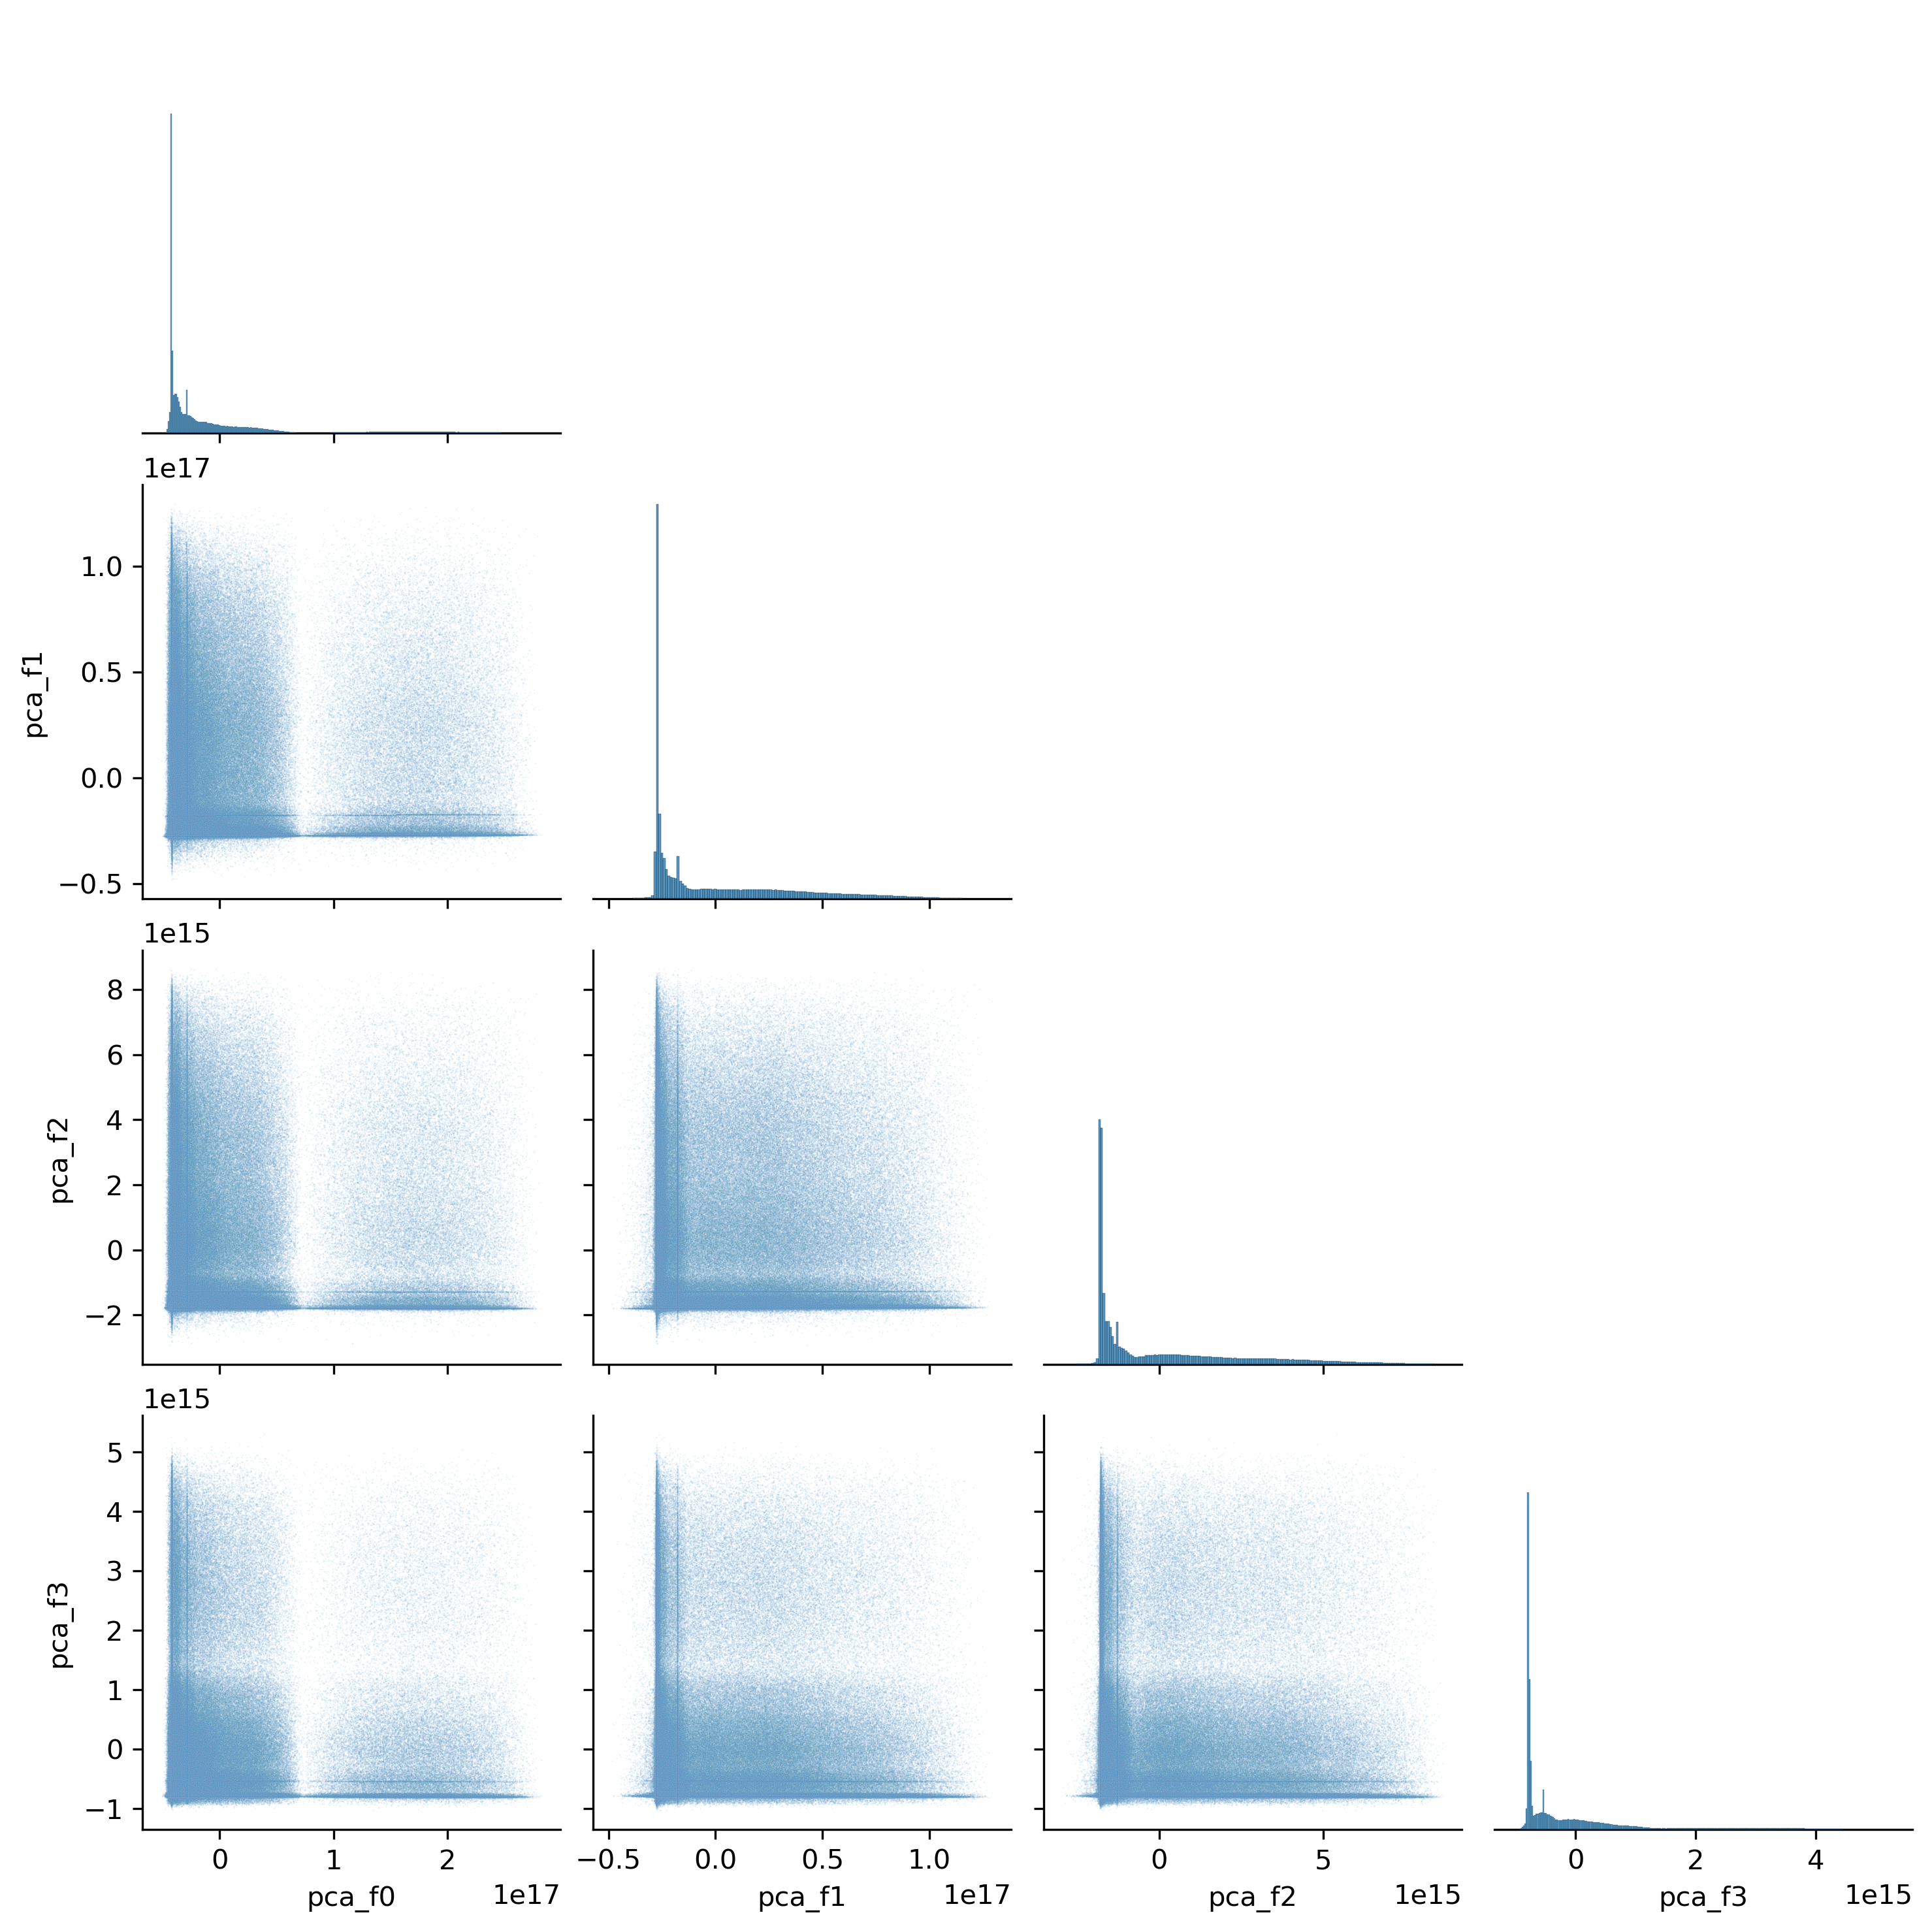

In [69]:
sns.pairplot(df_pca, corner=True,plot_kws=dict(marker=".", alpha=0.1,s=1))
plt.show()

Seaborn's pairplot is a quick and useful tool to check for correlation among variables. It performs best with smaller datasets both computationally and because of the amount of information it can provide. There is no obvious correlation between the variables, meaning we have captured 4 independent components in which the data-points seem to cover the entire space.

The histograms on the diagonal can also be seen as follows:

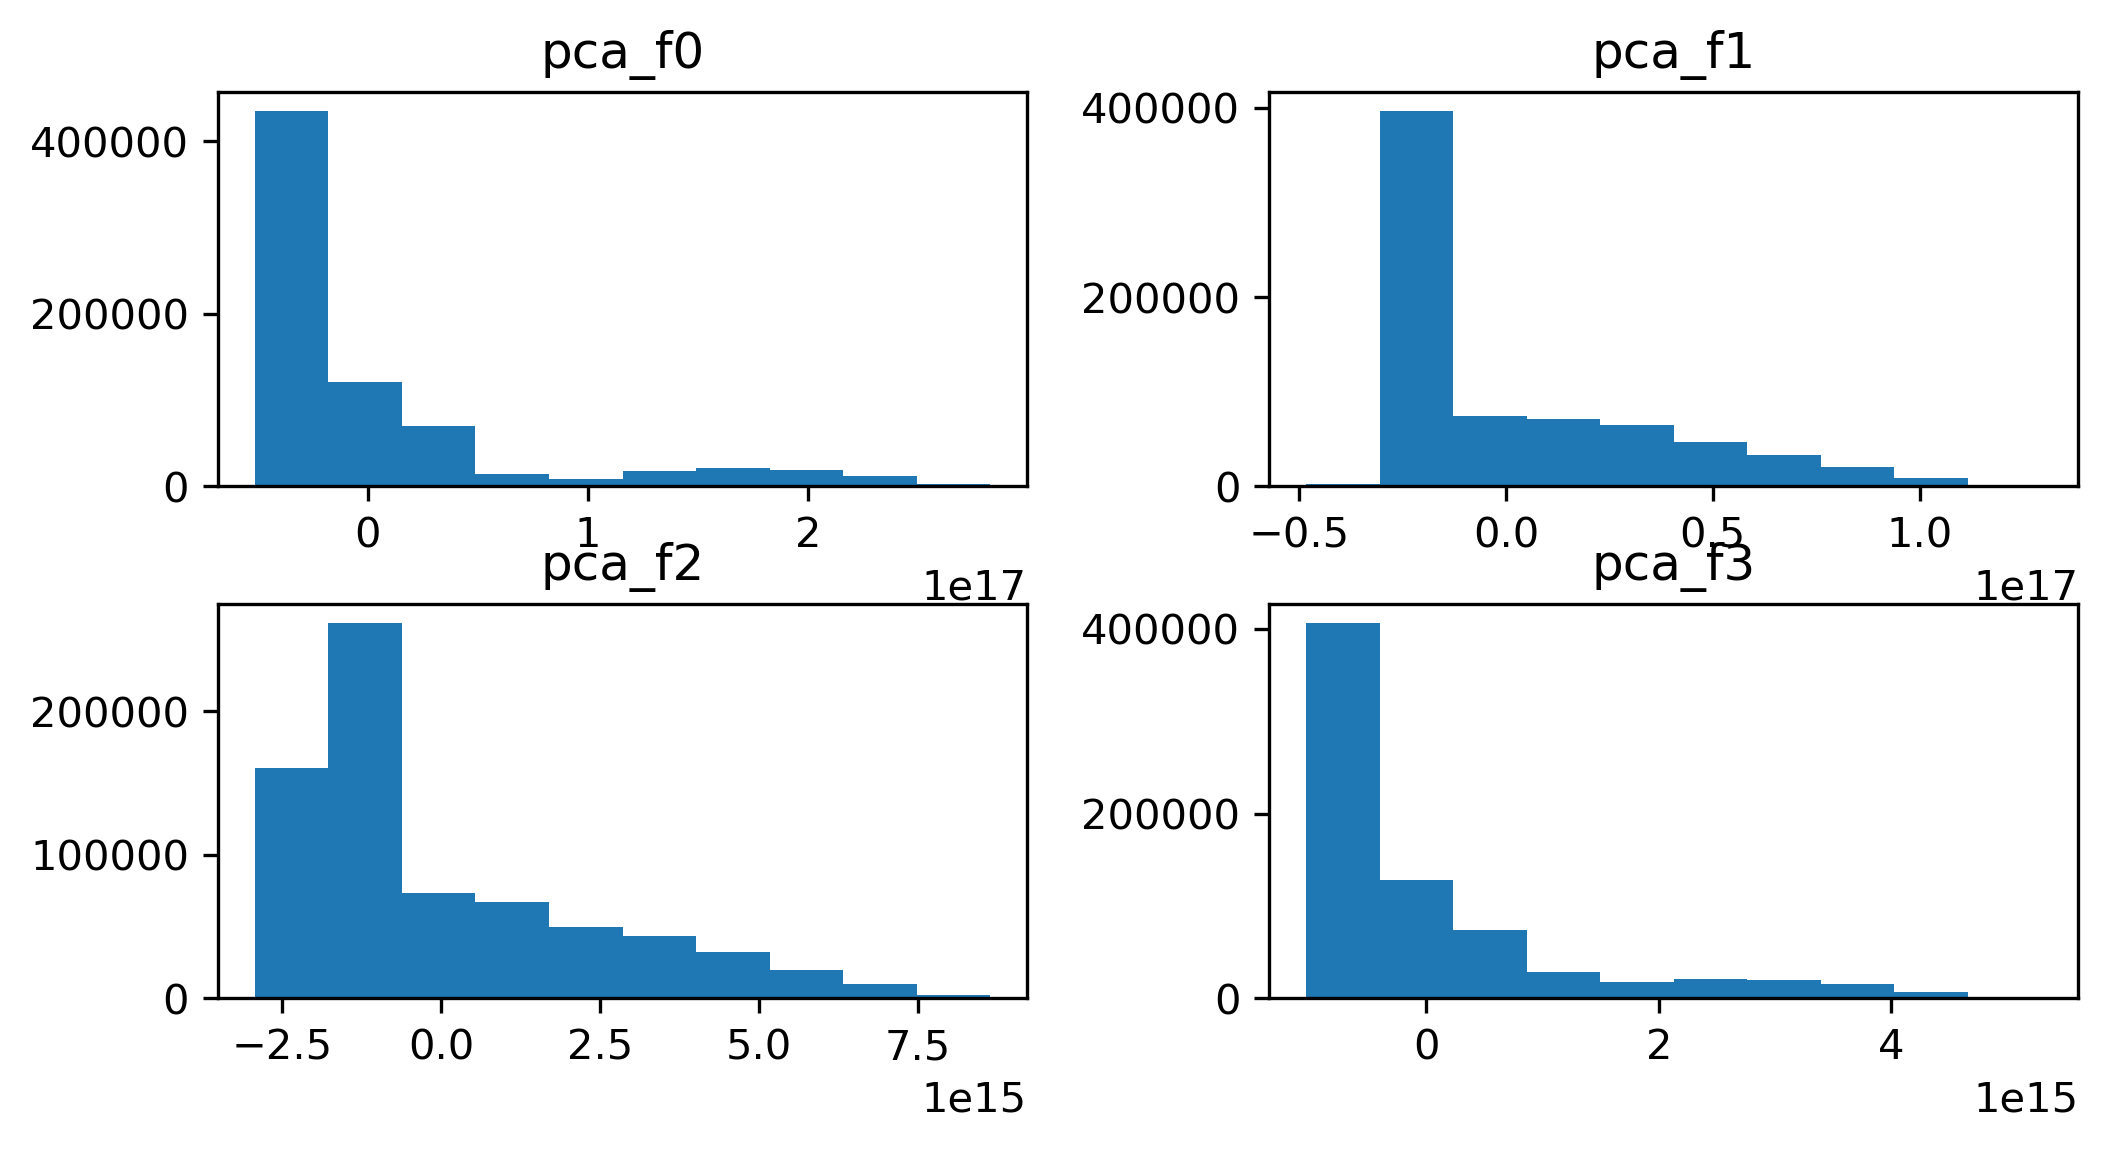

In [61]:
df_pca.hist(grid=False)
plt.show();

These 4 PCA features shows that they have a skewed distribution, so in order to rescale them we use the `PowerTransformer` which will take their logarithm and scale them so that the mean value $\mu = 0$ and their variance $\sigma^2=1$.

We use the default method of the `PowerTransformer`, ‘yeo-johnson’, as it works with both positive and negative values.

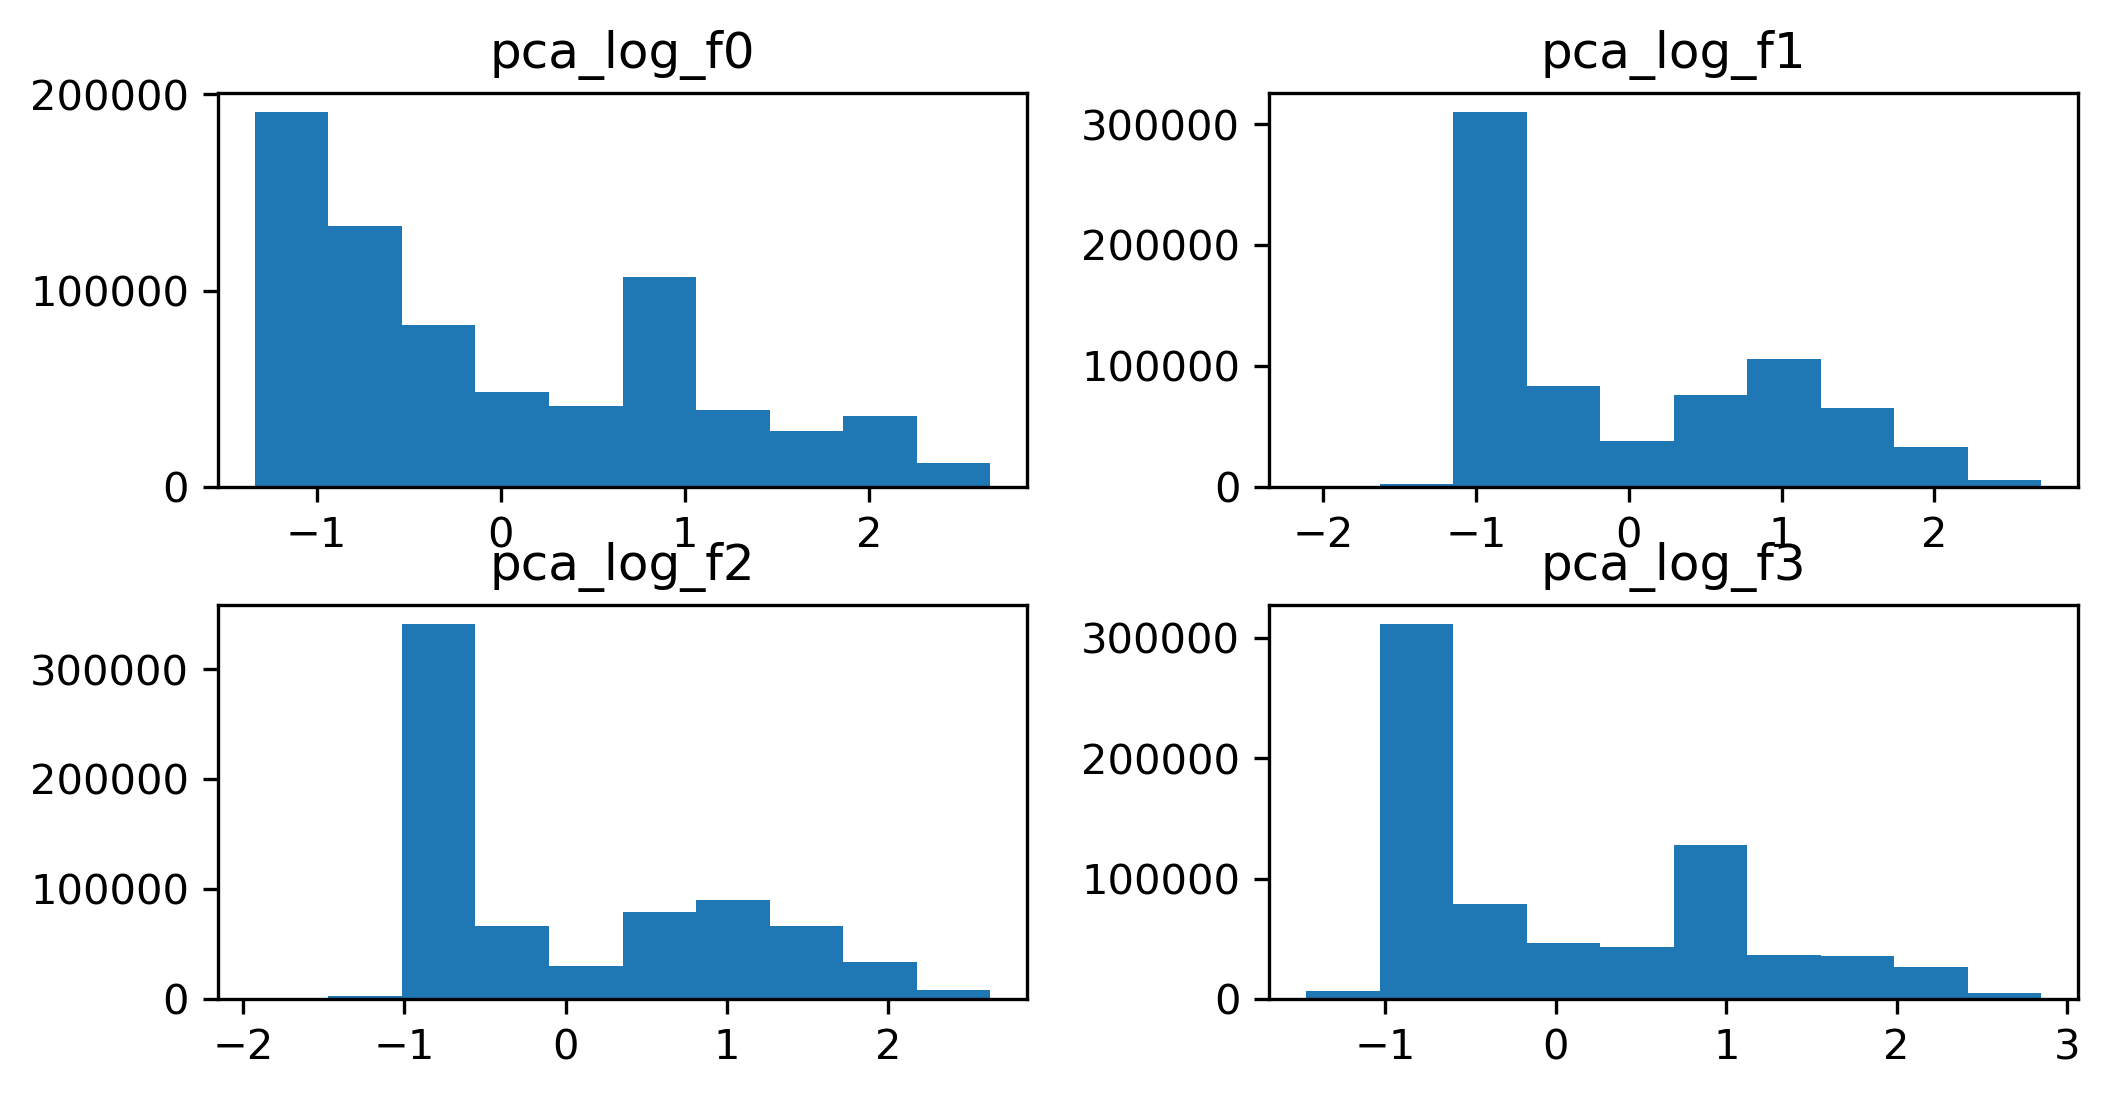

In [11]:
log = PowerTransformer()
log.fit(transformed)
log_transformed =log.transform(transformed)

df_pca_log = pd.DataFrame(log_transformed,columns=['pca_log_f'+str(n) for n in np.arange(4)])
df_pca_log.hist(grid=False)
plt.show();

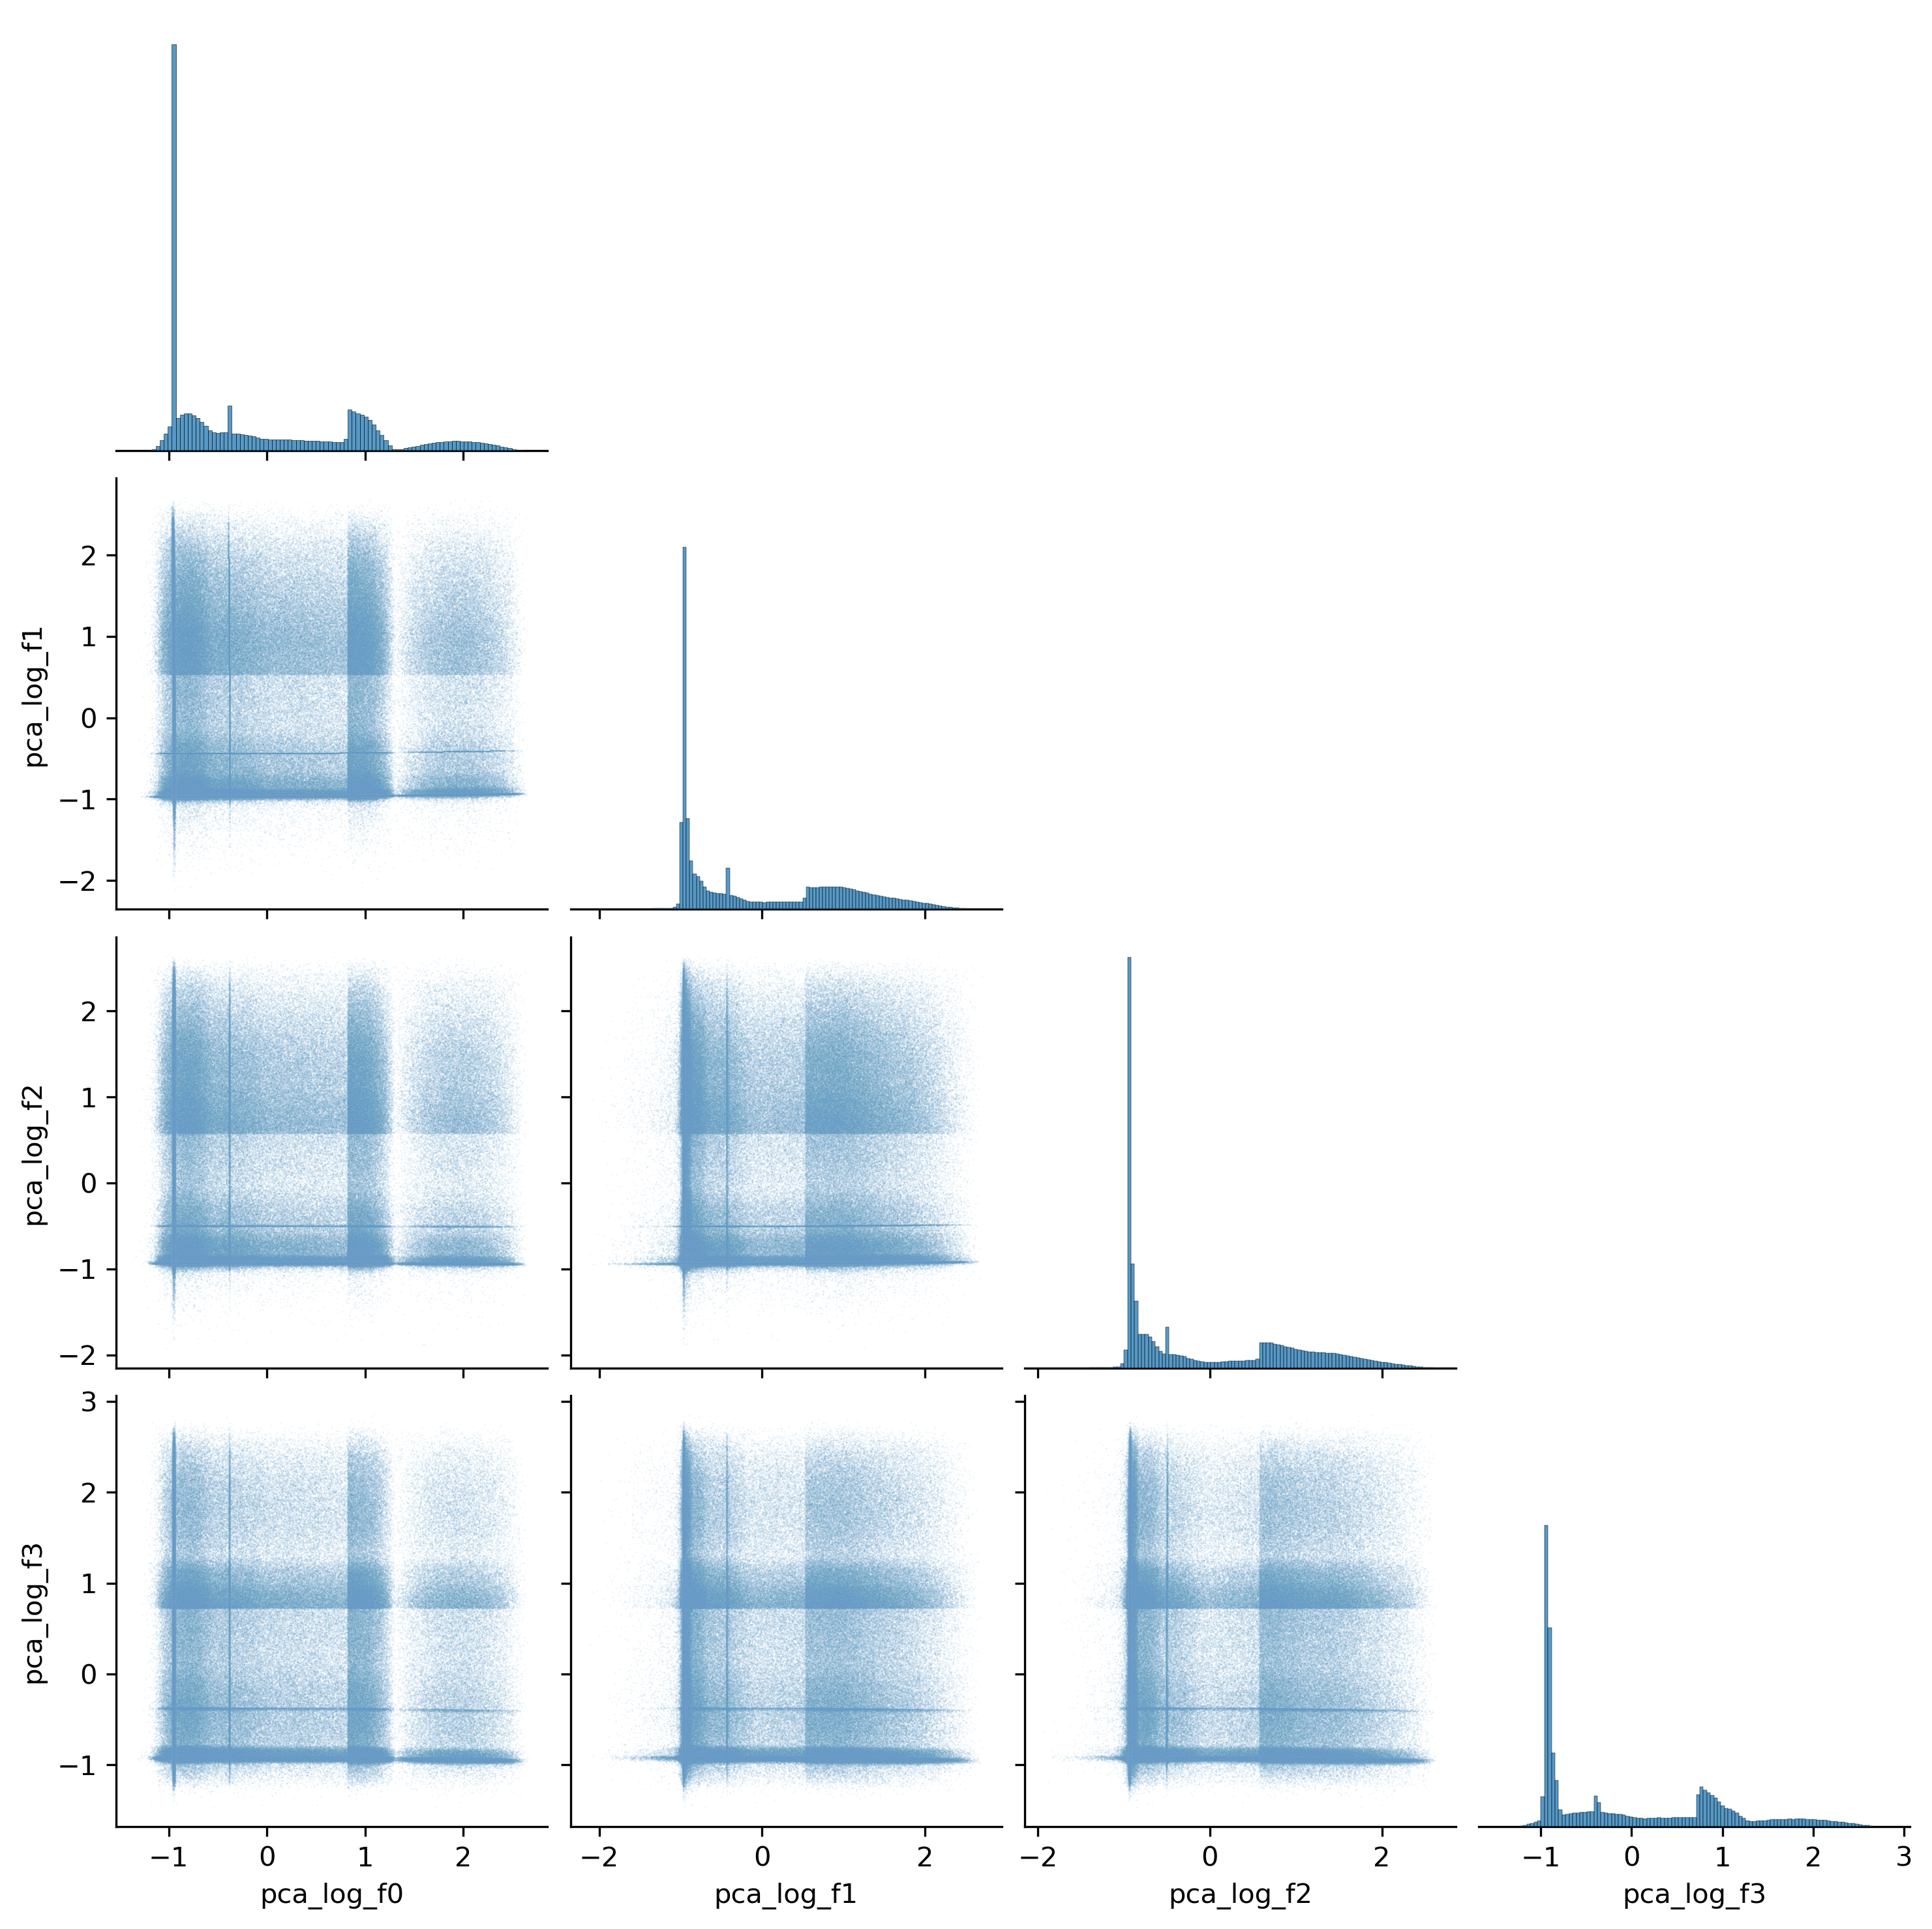

In [70]:
sns.pairplot(df_pca_log, corner=True,plot_kws=dict(marker=".", alpha=0.1,s=1))
plt.show()

A visual inspection in the two figures above shows that the skewness has been reduced, but not entirely removed.

Now we need to apply the same transformations to our test data so that then we can use the KNN model to predict on it.

In [12]:
X_test = imp.transform(X_test)
X_test = pca.transform(X_test)
X_test = log.transform(X_test)

## 3 Model Training
The KNN classifier uses the `k` hyper-parameter, which we want to "tune", i.e. we want to find an optimal number `k` of nearest neighbors based on which to perform the classification with the best accuracy. This is what we call hyper-parameter tuning. We explore a range of odd numbers, which is the typical choice for and even number of classification classes. There is normally no rule of thumb to choose the `k` value, and no dataset is the same. With a small number of neighbors the result will be more noisy, but a large number of neighbors make it computationally expensive, so ideally we want to keep it small.

In [31]:
neighbors = np.arange(1, 150, 4)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(log_transformed,y_train)
    
    #Compute accuracy on the training and testing set
    train_accuracy[i] = knn.score(log_transformed,y_train)
    test_accuracy[i] = knn.score(X_test, y_test)


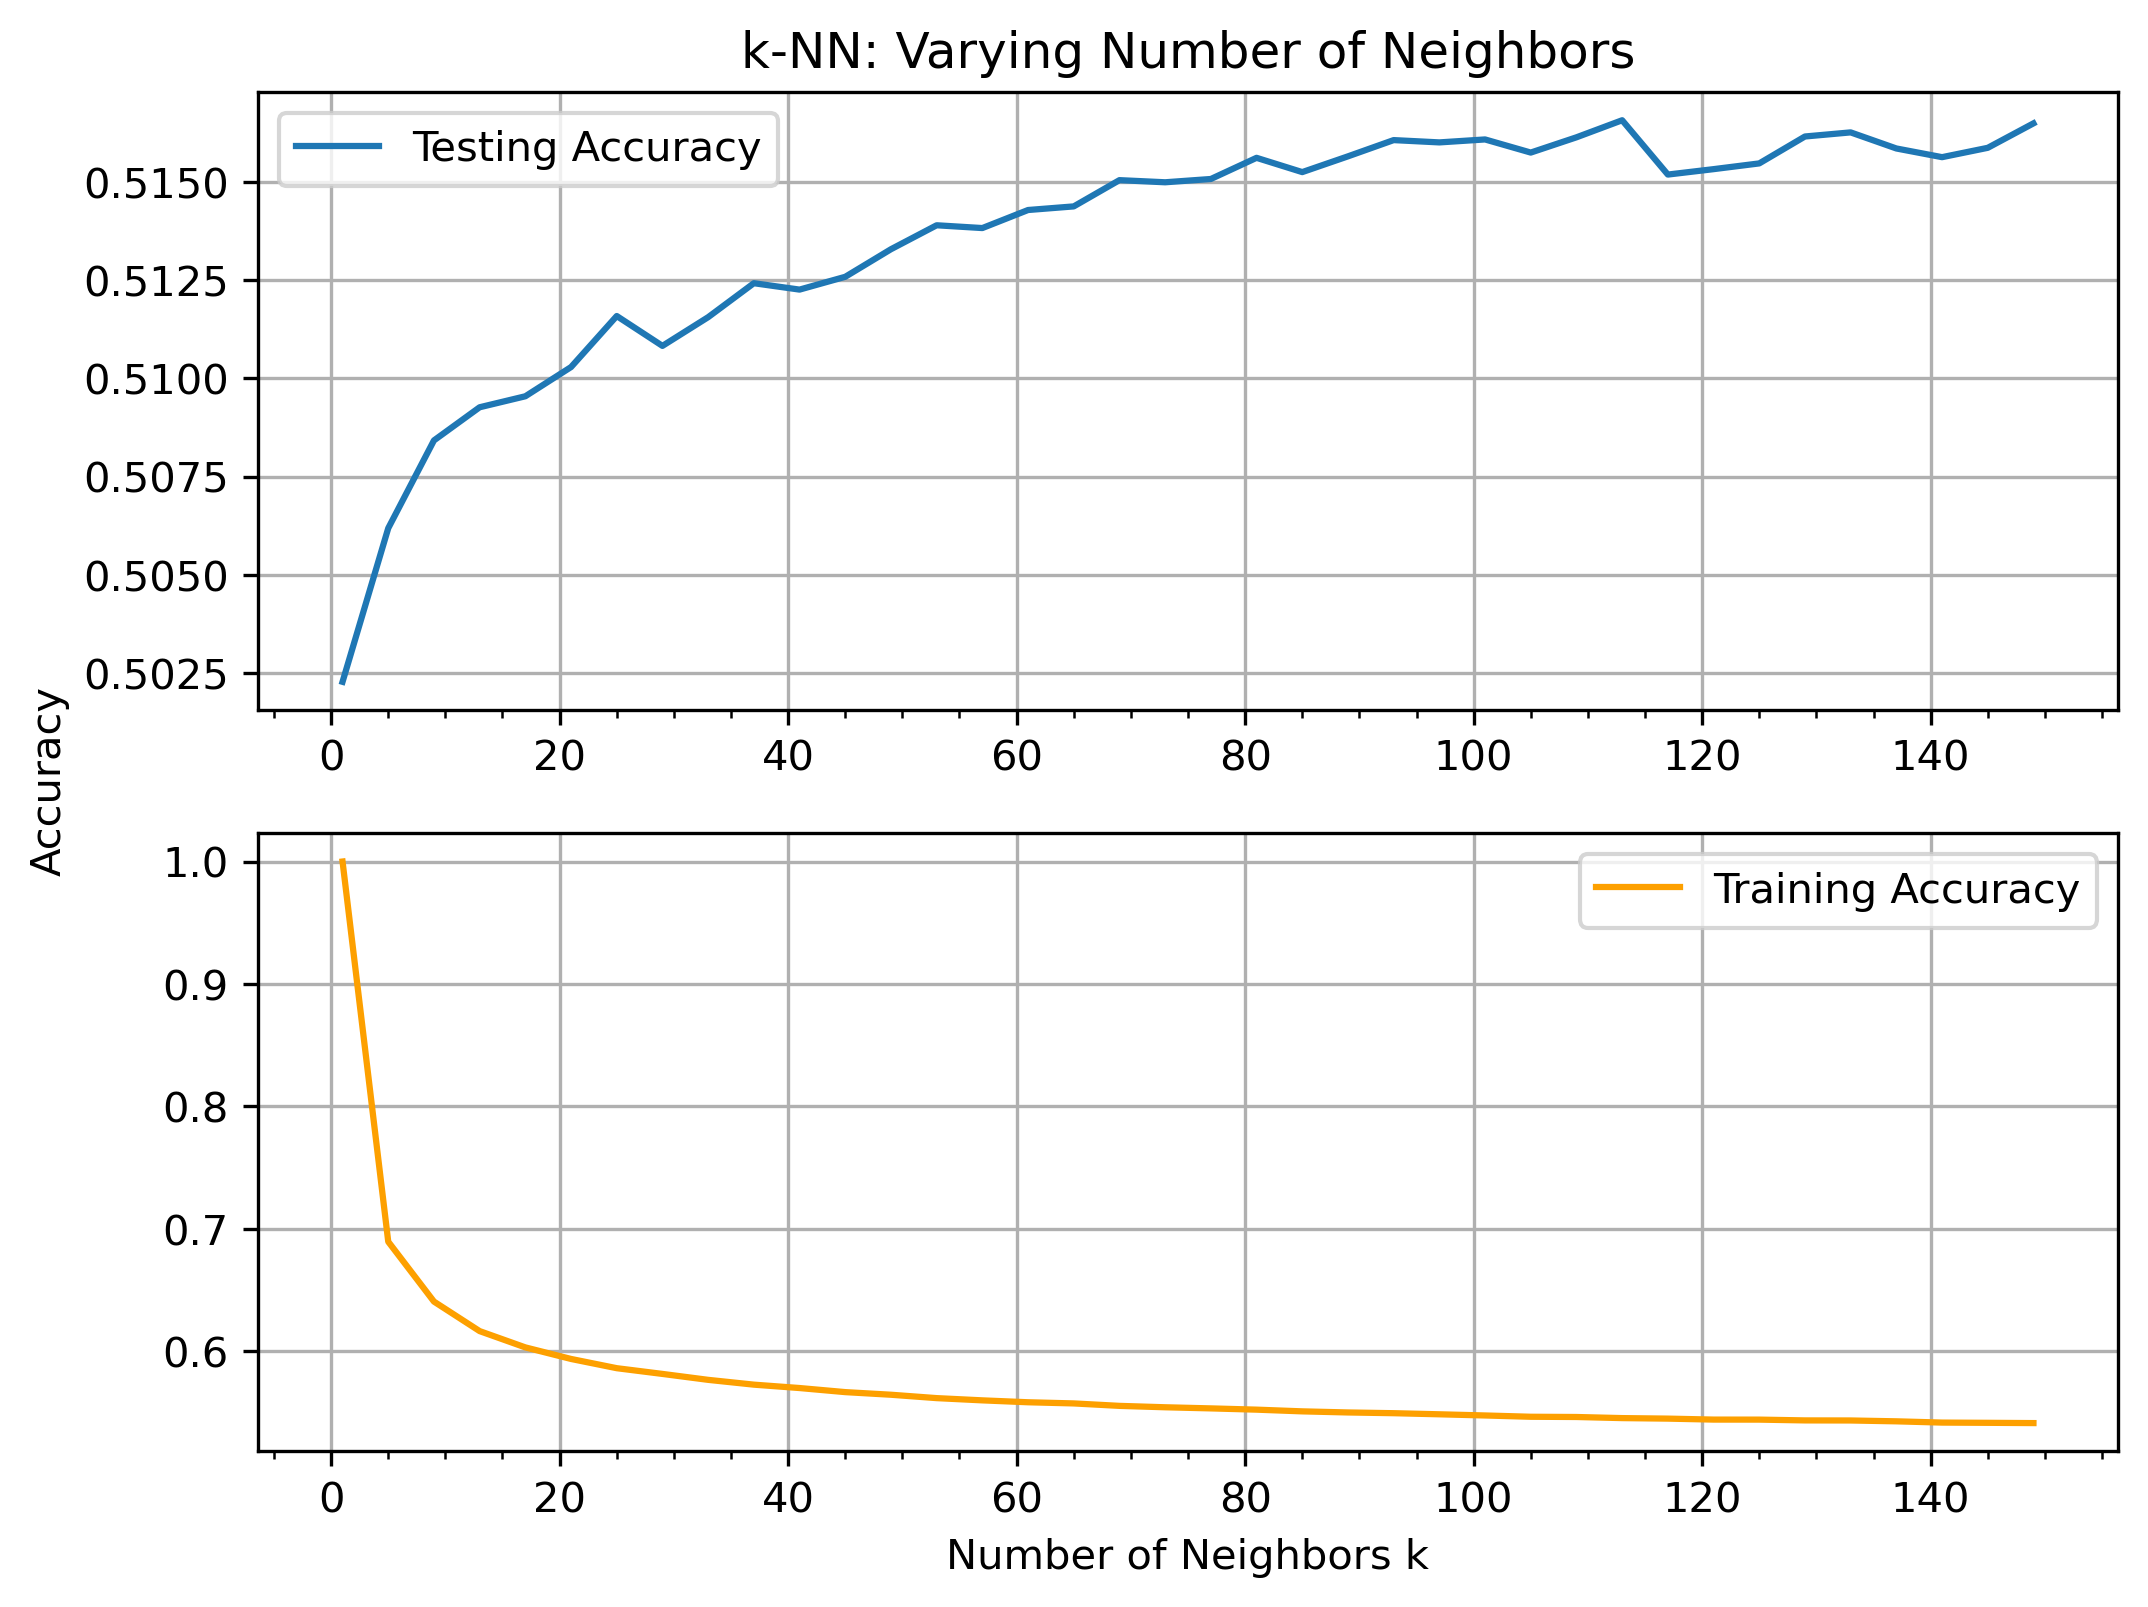

In [55]:
# Generate plot
fig, ax = plt.subplots(nrows=2,figsize=[8,6])
ax[0].set_title('k-NN: Varying Number of Neighbors')
ax[0].plot(neighbors, test_accuracy, label = 'Testing Accuracy')
ax[0].legend()
ax[0].grid(True)
ax[0].xaxis.set_minor_locator(MultipleLocator(5))

ax[1].plot(neighbors, train_accuracy, label = 'Training Accuracy',c="#fda000")
ax[1].legend()
ax[1].grid(True)
ax[1].xaxis.set_minor_locator(MultipleLocator(5))
ax[1].set_xlabel('Number of Neighbors k')
plt.text(x=0.03,y=0.45,s='Accuracy', rotation=90, transform=plt.gcf().transFigure)
plt.show()

We can see that at low `k` the model is overfitting the training data, while at high `k` the model tends asymptotically to 0.5 accuracy, which is the same as random guessing. 

On the other hand, the testing accuracy increases up to `k`~90, where it then seems to plateau. Nevertheless, the increase is small and the accuracy is never really good, so we choose a `k` value that is a compromise between overfitting and testing accuracy, at about `k`= 5-9. In particular I choose `k`= 7 as it is in between.

In [56]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(log_transformed, y_train) # (features, target_labels)

KNeighborsClassifier(n_neighbors=7)

## 4 Model Performance
In order to evaluate the model performance we predict the claims for the test data and compare the result with the test sample actual claims.
- Confusion matrix
- Classification report
- ROC curve

In [57]:
prediction = knn.predict(X_test)

In [72]:
knn_score=knn.score(X_test, y_test)
classif_report=classification_report(y_test, prediction)
cnf_matrix = confusion_matrix(y_test, prediction)

In [77]:
print(f'The KNN model score is: {knn_score:.2f}.')

The KNN model score is: 0.51.


The model score is its accuracy, i.e. the fraction of correct predictions that the model made. In our case this is ~52%, which is not great, as it is about as much we would get by throwing a coin. To be more precise the accuracy is defined as:
$${\rm accuracy}=\frac{tp + tn}{tp+tn+fp+fn}$$
where  $t$ stands for _true_, $f$ stands for _false_, $p$ stands for _positive_ (1) and $n$ stands for _negative_ (0). So accuracy measures the fraction of true positives (positives that were classified as positive by the model) and true negatives (negatives that were classified as negative by the model).

In [78]:
print(classif_report)

              precision    recall  f1-score   support

           0       0.51      0.51      0.51    120101
           1       0.51      0.51      0.51    119379

    accuracy                           0.51    239480
   macro avg       0.51      0.51      0.51    239480
weighted avg       0.51      0.51      0.51    239480



The other useful statistics that we can see in the classification report are:
- __precision__ (or positive predicted value):
$${\rm PPV}=\frac{tp}{tp+fp}$$
A high precision means that the classifier had a low false positive rate, i.e. customers who didn't make a claim, but were predicted to do so.

- __recall__(or true positive rate):
$${\rm TPR}=\frac{tp}{tp+fn}$$
A high recall means a low number of false negatives, i.e. customers who made a claim but were not predicted to do so.

- __F1 score__ (harmonic mean of precision and recall):
$$F_1=2\cdot\frac{\text{precision}\cdot\text{recall}}{\text{precision}+\text{recall}}$$
where an F1 score reaches its best value at 1 and worst score at 0.

The next interesting visualization is the confusion matrix, which can help us understand the values we found in the classification report. This allows us to evaluate whether the model performs better with positives or negatives and is particularly useful in the case of class imbalance, even though it is not our case.

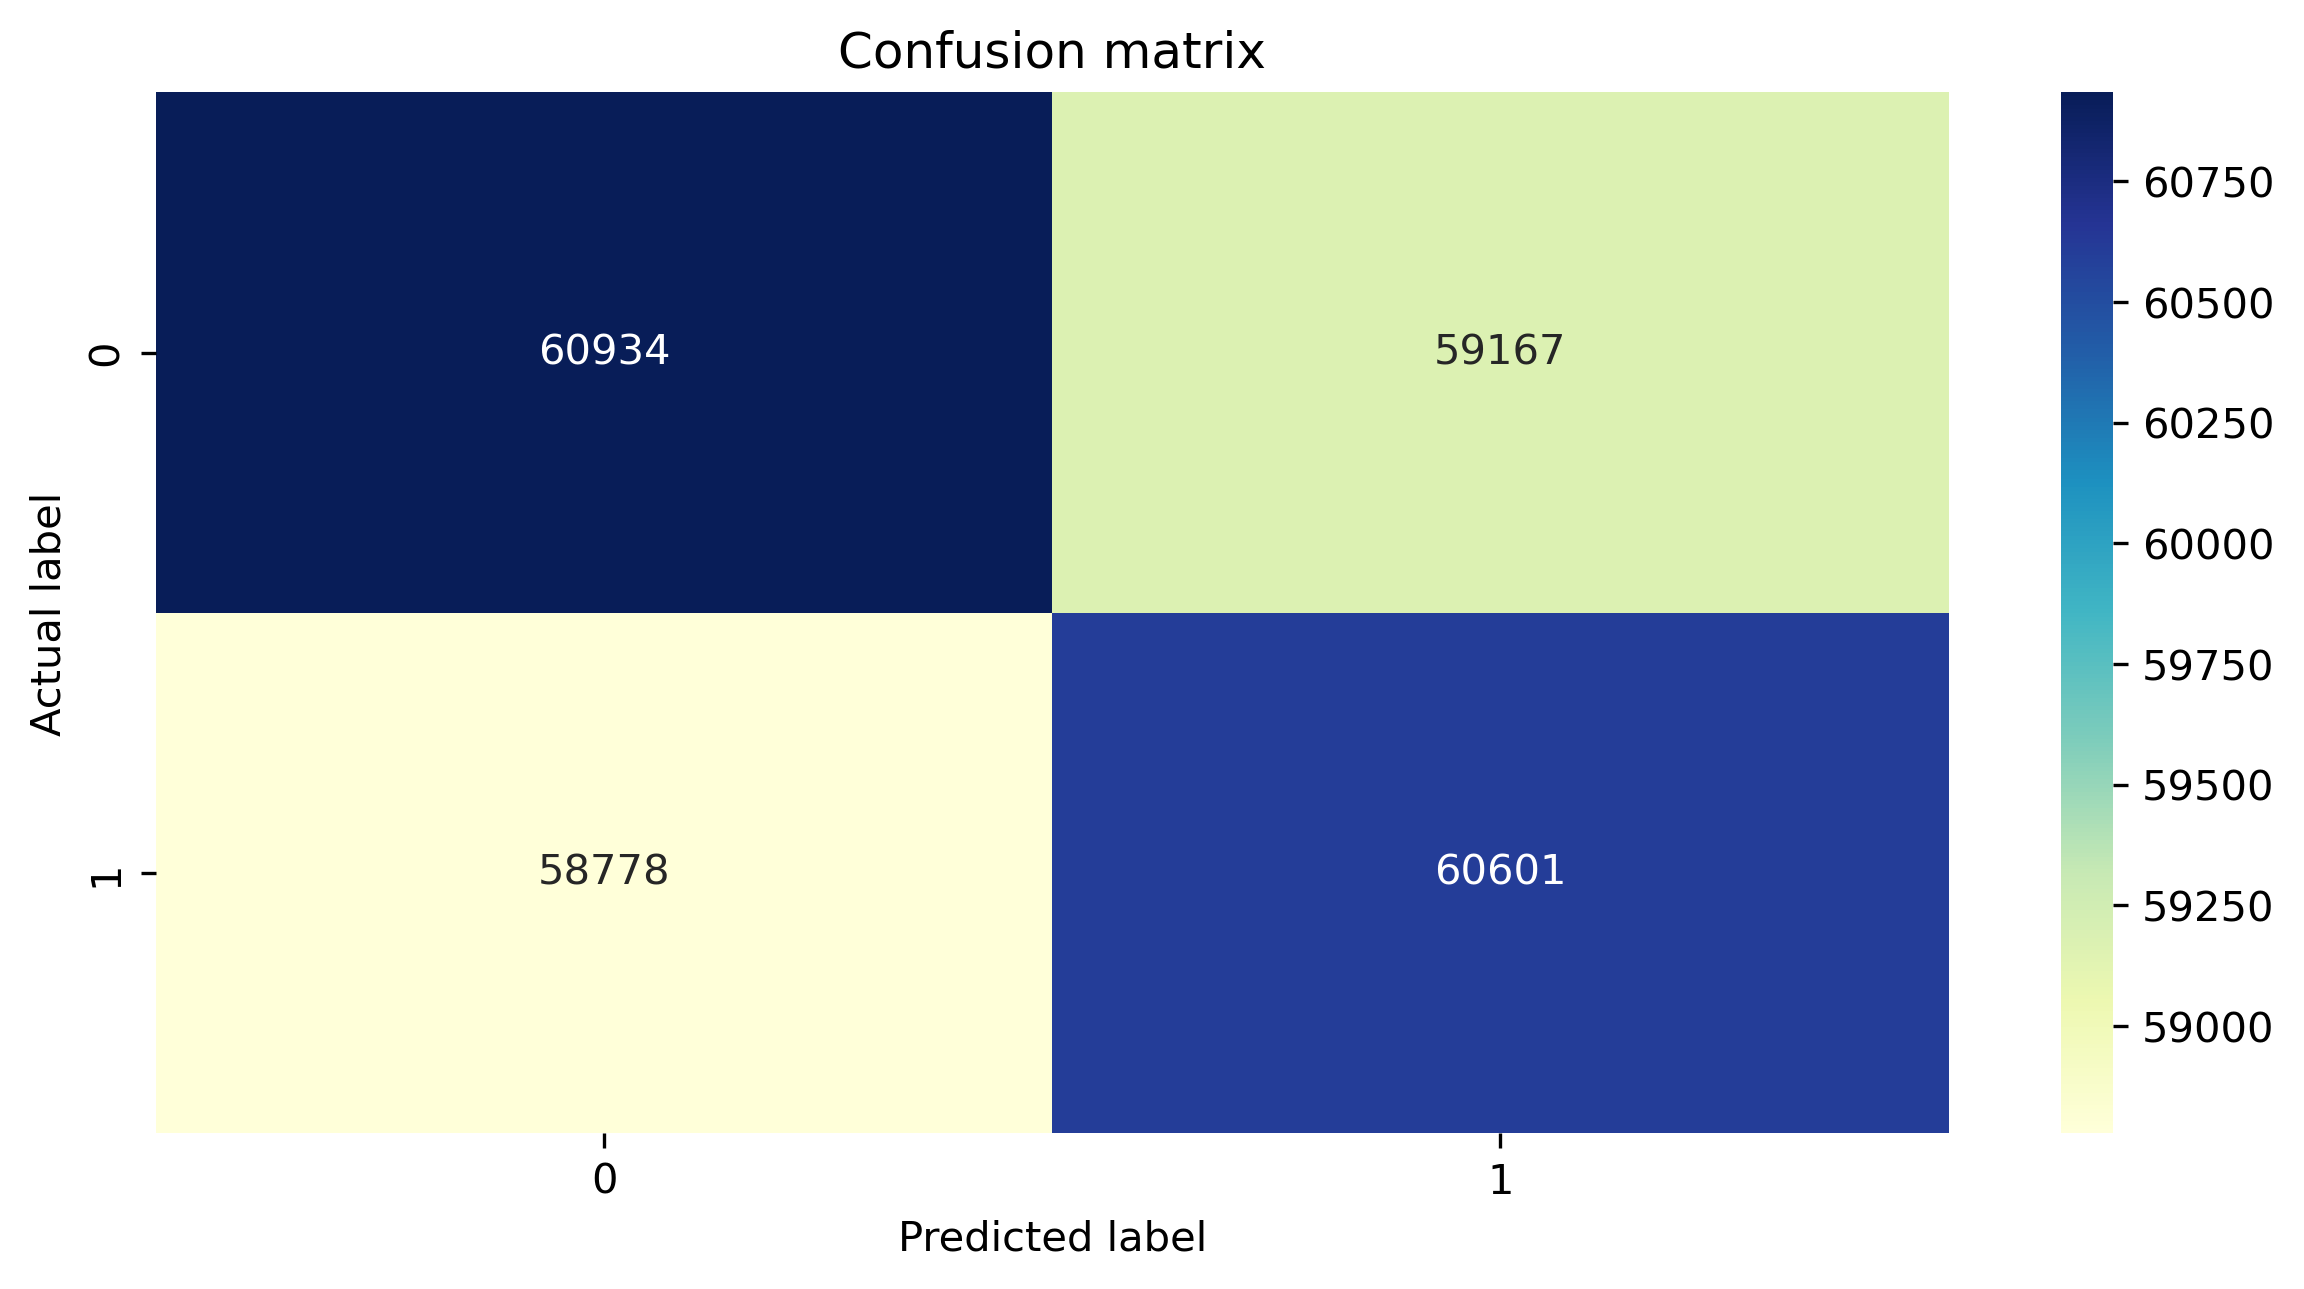

In [74]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

The confusion matrix is basically a table showing the amount of:

|                  | Predicted: Negative | Predicted: Positive | 

|------------------|---                  |---                 |

|Actual: Negative  | True Positive       | False Negative     |

|Actual: Poisitve  | False Positive      | True Negative      | 

![Confusion Matrix](./confusion_matrix.jpg)

(I am including both markdown and figure since I'm having trouble visualizing either)

We can see from the colorbar that the range of values is not so broad, so in each field we have similar numbers. This explains why the classification report always showed the same number for all statistics, as by rounding the fractions these are all about the same, and the classification report is not very informative in this case of bad performance.

Despite the similar numbers in each field of the confusion matrix, the number of both true positives and true negatives is consistently higher than the amount of false negatives and false positives. Our model still has a lot to learn, we probably oversimplified the problem by reducing it to 4 features only, but it is starting grasp what rules the presence claims or lack thereof.

The Receiver Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rate that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. This is useful in the case of a probability prediction, like the logistic regression, where we can change the probability threshold in order to define the label. AUC score is Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores. An AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

In our case, in which we didn't retrieve probabilities from the model and we have an accuracy of ~0.5, the ROC curve is obviously the bisector line, and the area below it is ~0.5 (see legend in figure below).

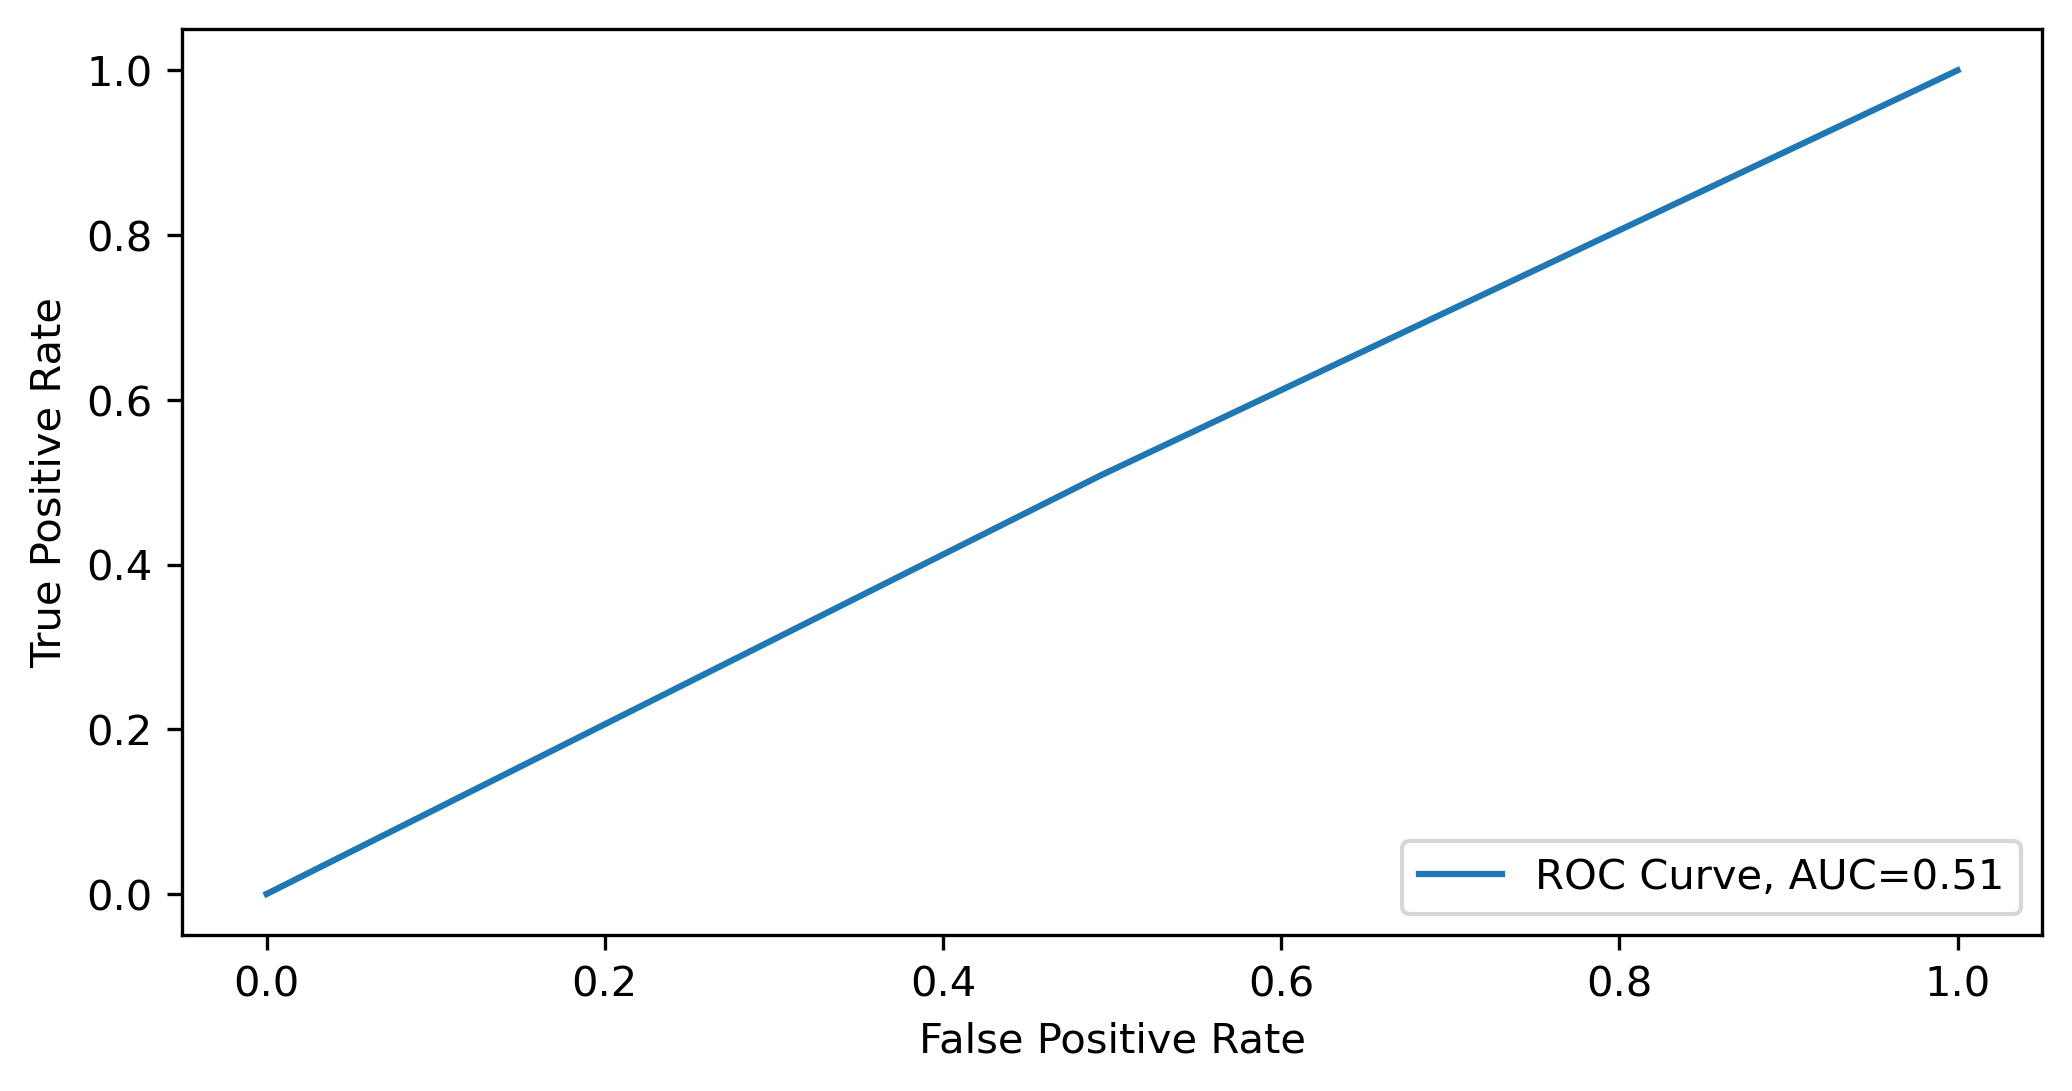

In [85]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test,  prediction)
auc = roc_auc_score(y_test, prediction)
plt.plot(fpr,tpr,label=f"ROC Curve, AUC={auc:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()